In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import datetime
from tqdm import tqdm

import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
# matplotlib.font_manager._rebuild()
# plt.rc('font', family='NanumGothic')

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler

from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

In [3]:
panel = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_df.csv')
panel = panel.iloc[:,1:].reset_index(drop=True)
train_data1_2 = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_row_to_col.csv').iloc[:,1:]
train_data1_3 = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_growth_rate.csv').iloc[:,1:]
train_data1_4 = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_non_linear.csv').iloc[:,1:]

# #1. 전처리 & 파생변수

In [4]:
panel = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_df.csv')
panel = panel.iloc[:,1:].reset_index(drop=True)

# return 변수 float
panel['return'] = panel['return'].astype(str)
panel['return'] = [re.sub(",", "", row) for row in panel['return']]
panel['return'] = panel['return'].astype(float)

# astype 또는 to_datetime로 변환
# panel['year'] = panel['year'].astype(str)
panel['최초상장일자'] = panel['최초상장일자'].astype(str)
panel['상장일자'] = panel['상장일자'].astype(str)
panel['최초상장일자'] = [re.sub(".0$", "", row) for row in panel['최초상장일자']]
panel['상장일자'] = [re.sub(".0$", "", row) for row in panel['상장일자']]
panel['최초상장일자'] = pd.to_datetime(panel['최초상장일자'])
panel['상장일자'] = pd.to_datetime(panel['상장일자'])

panel['unlist_year'] = panel['unlist_date'].str.slice(stop=4)
# panel['unlist_date'] = pd.to_datetime(panel['unlist_date'])
# panel['Accounting_Closing'] = panel['Accounting_Closing'].astype(int) #오류남
panel['unlist_reason'] = panel['unlist_reason'].astype(str)

# 금융회사 제외
panel = panel[panel['대분류']!='금융 및 보험업']
panel = panel.drop(['대분류', '세분류', '세세분류','소분류', '중분류', '코드세분류', '코드세세분류', '코드소분류', '코드중분류', '주거래은행'], axis=1)

## (2) 상장폐지 사유 전처리 & 카테고리화

In [5]:
panel['unlist_reason_ctg'] = panel['unlist_reason']

## 상장폐지신청 dict로 class화
ctg_dict = {}
ctg_list = ['(상장폐지 ?신청)|(^신청)','(신청)|(요청)|(자진)',"(상장$)|(^시장)|(^증권)",'(편입)|(흡수)',"지주회사", "영업의 양도", "기타", "계약이전",
            '해산', "부도", '전액', '자본', "(^감사(으로)? ?의견( 의견)? ?거절)|(범위 ?제한)|(감사의견 ?부적정)|(감사의견거절)", "경영",
            "(시가 ?총액)|(시총)","주식","보통주", "정리", "영업", "유예", "정지", "제출", "부진", "액면가", "불성실", "화의 불인가", "회생"]

for ctg in ctg_list:
  r = re.compile(ctg)
  v = list(set([row for row in panel['unlist_reason_ctg'] if r.search(row) is not None]))
  k = min(v, key=len)
  ctg_dict[k] = v
  panel['unlist_reason_ctg'] = panel['unlist_reason_ctg'].replace(v, '0')

# keys 이름 수정
# ctg_dict["자본잠식률 50% 이상"] = ctg_dict["2회연속 자본잠식률 50%이상"]
# ctg_dict["불성실공시법인지정"] = ctg_dict["최근 2년간 3회이상 불성실공시법인으로 지정"]

# del ctg_dict["2회연속 자본잠식률 50%이상"], ctg_dict["최근 2년간 3회이상 불성실공시법인으로 지정"]

In [6]:
ctg_dict.keys()

dict_keys(['신청에 의한 상장폐지', '자진등록취소', '코스닥시장 상장', '피흡수합병', '지주회사(최대주주등)의 완전자회사화 등', '주된영업의 양도', '기타 등록취소', '계약이전', '해산 사유 발생', '부도', '자본전액잠식', '2회연속 자본잠식률 50%이상', '감사의견거절', '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당', '시가총액 미달', '주식양도 제한', '보통주 주가수준미달', '회사정리절차 폐지 결정', '영업활동정지 6월 계속', '상장폐지유예기간종료', '당좌거래정지', '공시서류 미제출(반기보고서) 후 차기보고서 미제출', '2분기 연속 거래실적부진사유 미해소', '액면가액일정비율 미달', '최근 2년간 3회이상 불성실공시법인으로 지정', '화의 불인가', '회생절차폐지결정사유 및 당해 코스닥시장상장법인의 계속기업 가능성 유무를 고려한 결과 상장폐지기준에 해당한다고 결정'])

In [7]:
## dict로 replace
panel['unlist_reason_ctg'] = panel['unlist_reason']

# values에 해당되면 key로 치환
key_list = []

for reason in panel['unlist_reason_ctg']:
  key = [k for k, v in ctg_dict.items() if reason in v]
  if len(key)==0:
    key_list.extend(reason)
  else:
    key_list.extend(key)

panel['unlist_reason_ctg'] = key_list
panel[panel['unlist_reason_ctg']!=panel['unlist_reason']][['unlist_reason_ctg', 'unlist_reason']]

,unlist_reason_ctg,unlist_reason
76864,자본전액잠식,자본전액잠식 2년 계속
76865,자본전액잠식,자본전액잠식 2년 계속
76866,자본전액잠식,자본전액잠식 2년 계속
76867,자본전액잠식,자본전액잠식 2년 계속
76868,자본전액잠식,자본전액잠식 2년 계속
...,...,...
111899,신청에 의한 상장폐지,상장폐지 신청('22.04.14)
111900,신청에 의한 상장폐지,상장폐지 신청('22.04.14)
111901,신청에 의한 상장폐지,상장폐지 신청('22.04.14)
111902,신청에 의한 상장폐지,상장폐지 신청('22.04.14)


## (3) 재무부실 사유 상장폐지기업 class 파생변수

In [8]:
## 재무적 이유로 상장폐지 하지 않은 사유 필터
panel['fnc_rsn_unlst_year'] = panel['unlist_reason_ctg']

panel['fnc_rsn_unlst_year'] = panel['fnc_rsn_unlst_year'].replace(['해산 사유 발생', '영업활동정지 6월 계속', '자본전액잠식', '회사정리절차 폐지 결정',
                                                         '감사의견거절', '주식양도 제한', '상장폐지유예기간종료', '부도',
                                                         '보고서 또는 서류 미제출', '자본잠식률 50% 이상', '시가총액 미달', '보통주 주가수준미달',
                                                         '당좌거래정지', '액면가액일정비율 미달', '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당',
                                                         '화의 불인가', '불성실공시법인지정', '2분기 연속 거래실적부진사유 미해소', '사업보고서 법정제출기한 익일부터 10일이내 미제출',
                                                         '회생절차폐지결정사유 및 당해 코스닥시장상장법인의 계속기업 가능성 유무를 고려한 결과 상장폐지기준에 해당한다고 결정','공시서류 미제출(반기보고서) 후 차기보고서 미제출',
                                                         '공시서류 미제출(사업보고서) 후 10일이내 미제출', '2연속 자본잠식률 50% 이상','최근 2년간 3회이상 불성실공시법인으로 지정', '2회연속 자본잠식률 50%이상'],'1')

panel['fnc_rsn_unlst_year'] = panel['fnc_rsn_unlst_year'].replace(['피흡수합병','자진등록취소','신청에 의한 상장폐지', '지주회사(최대주주등)의 완전자회사화 등',
                                                          '코스닥시장 상장', '기타 등록취소', '주된영업의 양도','계약이전','증권거래소 상장'],'0')

panel[['unlist_reason_ctg', 'fnc_rsn_unlst_year']] # {상장폐지X, 그외사유 상장폐지: 0}, {재무사유 상장폐지: 1}

,unlist_reason_ctg,fnc_rsn_unlst_year
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
111899,신청에 의한 상장폐지,0
111900,신청에 의한 상장폐지,0
111901,신청에 의한 상장폐지,0
111902,신청에 의한 상장폐지,0


In [9]:
panel['fnc_rsn_unlst_year'].unique()


array(['0', '1'], dtype=object)

## (4) 기업코드 레이블 인코딩

In [10]:
## 기업코드 레이블 인코딩
panel['code_label'] = [int(re.sub("^A", "", row) )for row in panel['code']]

In [11]:
## 되돌리기 위한 매칭 함수 {기업코드_int:기업코드}
def df_to_dict(df, keys_col, values_col):

  trans = df.loc[:,[keys_col, values_col]].transpose()
  trans.columns = trans.iloc[0]
  trans = trans.iloc[1].to_dict()

  for k in list(trans.keys()):
    if pd.isnull(trans[k])==True:
      del trans[k]

  return trans

# code_dict = df_to_dict(panel, 'code_label','code')
# print(code_dict)

## (5) 결측치 제거
- 재무정보columns('cash/assets':'retained_earning')이 모두 Nan값인 경우만 row drop
- 열 하나라도 Nan값이 아니라면 drop하지 않음
- 주가정보 제외하고 재무정보가 없으면

In [14]:
panel.dropna(subset = panel.loc[:,'cash/assets':'net_income_grow'].columns,axis = 0, how='all').reset_index(drop=True).apply(lambda x: pd.isna(x).sum())

code                                     0
cor_name                                 0
Accounting_Closing                       0
year                                     0
cash/assets                              6
liabilities/assets                       5
liabilities-cash/assets                  5
sales/cur_liabilities                    6
cur_assets/cur_liabilities               5
retained_earnings/cur_liabilities        6
non_cur_lia/non_cur_lia+worth            6
interest/cash_flow                      13
interest/ebitda                         23
inven/sales                            158
sales/net_income                        13
gross_margin/sales                     191
sales/retained_earnings                 15
change_in_roa                         9303
change_in_AR                          2896
change_in_TP                          4317
assets                                   5
sales                                    0
roa                                   4691
sales_grow 

In [12]:
# panel = panel.dropna(subset = panel.loc[:,'cash/assets':'net_income_grow'].columns,axis = 0, how='all').reset_index(drop=True)
panel.apply(lambda x: pd.isna(x).sum())

code                                     0
cor_name                               128
Accounting_Closing                    1355
year                                     0
cash/assets                          45382
liabilities/assets                   45381
liabilities-cash/assets              45381
sales/cur_liabilities                45382
cur_assets/cur_liabilities           45381
retained_earnings/cur_liabilities    45382
non_cur_lia/non_cur_lia+worth        45382
interest/cash_flow                   45389
interest/ebitda                      45399
inven/sales                          45534
sales/net_income                     45389
gross_margin/sales                   45567
sales/retained_earnings              45391
change_in_roa                        54679
change_in_AR                         48272
change_in_TP                         49693
assets                               45381
sales                                45376
roa                                  50067
sales_grow 

In [13]:
panel.shape

(101280, 44)

## (6) 상장폐지 날짜 class 형태 파생변수

In [15]:
## 상장폐지일이 지난 후에도 재무정보가 있는 행 drop
panel['unlist_year'] = panel['unlist_year'].fillna(10000).astype(int)
panel_a = panel[panel['year']<=panel['unlist_year']].reset_index(drop=True) # year > unlist_year인 행 제외

In [16]:
## 상장폐지일이 지난 후에 회계결산한 재무정보 행 drop (월이 같아도 회계결산은 월말에 이뤄지므로 같거나 회계결산월이 더 크면 drop)
panel_a['unlist_mon'] = panel_a['unlist_date'].str.slice(start=5, stop=7)
panel_a['unlist_mon'] = panel_a['unlist_mon'].fillna(10000).astype(float)
panel_a = panel_a[(panel_a['year']!=panel_a['unlist_year'])|((panel_a['year']==panel_a['unlist_year'])&(panel_a['Accounting_Closing']<panel_a['unlist_mon']))].reset_index(drop=True)
print(54920-220)
print(panel_a.shape)

54700
(88267, 45)


In [17]:
## [선택]
### (1) 오직 전년도 재무정보를 가지고 다음해 상장폐지를 예측할 것인가? -> 아래 코드 필요 O
### (2) 상장폐지 당해 연도 재무정보가 반영되어 상장폐지가 결정된 경우도 고려할 것인가? (상장폐지 당해연도 재무정보 사용할 것인가?) -> 아래코드 필요X
print(54920-220-10)
# panel_a = panel_a[panel_a['year']!=panel_a['unlist_year']].reset_index(drop=True)
panel_a

54690


,code,cor_name,Accounting_Closing,year,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning,closing_price,revised_price,market_capital,return,코드대분류,최초상장일자,상장일자,unlist_date,unlist_reason,bsn_code,grngas,unlist_year,unlist_reason_ctg,fnc_rsn_unlst_year,code_label,unlist_mon
0,A005930,삼성전자,12.0,1990,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,4.259878e+08,3.677766e+08,33000.0,429.0,1376850.0,NaN,C,1975-06-11,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
1,A005930,삼성전자,12.0,1991,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,6.647707e+08,4.030919e+08,31300.0,310.0,1479532.0,NaN,C,1975-06-11,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
2,A005930,삼성전자,12.0,1992,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,8.341670e+08,4.395800e+08,33300.0,313.0,1728236.0,8.17,C,1975-06-11,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
3,A005930,삼성전자,12.0,1993,0.033530,0.793795,0.760265,2.495139,0.815311,0.162677,0.649281,0.000000,0.000000,0.124302,113.547603,0.308030,15.337989,-0.147541,-0.127702,-0.419701,8.447099e+09,8.684668e+09,1.04,42.31,7.648482e+07,5.590000,2.675142e+09,1.307651e+09,5.662195e+08,57400.0,336.0,3329269.0,77.95,C,1975-06-11,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
4,A005930,삼성전자,12.0,1994,0.022999,0.692778,0.669779,3.189266,1.128719,0.412265,0.501214,0.000000,0.000000,0.098240,11.736092,0.375319,7.735951,9.682692,0.278744,-0.079209,9.603379e+09,1.176292e+10,11.11,35.44,1.002286e+09,1210.440000,4.414842e+09,2.635296e+09,1.520553e+09,109000.0,589.0,6715822.0,94.40,C,1975-06-11,1975-06-11,NaN,0,124-81-00998,NaN,10000,0,0,5930,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88262,A950180,SNK,7.0,2017,0.611887,0.168936,-0.442952,4.380337,5.477438,2.218058,0.005800,0.020936,0.018697,0.000820,1.830197,0.890897,1.974852,NaN,NaN,NaN,7.581997e+07,5.449621e+07,NaN,NaN,2.977615e+07,NaN,4.855051e+07,3.339438e+07,2.759508e+07,NaN,NaN,NaN,NaN,J,2019-05-07,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0
88263,A950180,SNK,7.0,2018,0.527099,0.165288,-0.361812,4.341584,6.356767,3.357695,0.019078,0.000000,0.000000,0.028286,2.734232,0.872833,1.293025,NaN,0.027818,0.856271,1.049511e+08,6.791689e+07,27.48,24.63,2.483948e+07,-16.580000,5.928011e+07,3.704637e+07,5.252557e+07,NaN,NaN,NaN,NaN,J,2019-05-07,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0
88264,A950180,SNK,7.0,2019,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,0.010316,0.000000,0.000000,0.006349,3.274688,0.792945,1.146334,-0.467249,-0.211815,0.047309,3.209885e+08,1.020694e+08,14.64,50.29,3.116920e+07,25.480000,8.093543e+07,4.716452e+07,8.903985e+07,18800.0,33650.0,395962.0,-52.45,J,2019-05-07,2019-05-07,2022-05-18,상장폐지 신청('22.04.14),000-81-20024,NaN,2022,신청에 의한 상장폐지,0,950180,5.0
88265,A950180,SNK,7.0,2020,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,0.014456,0.006268,0.005792,0.009289,3.796404,0.846271,0.745314,-0.542350,-0.183378

In [18]:
## 위의 조건 drop후, 마지막 연도 재무정보에 라벨링 == '1'
panel_a['unlist_last_year'] = '0'
unlist_cor = list(panel_a[panel_a['unlist_date'].notnull()]['cor_name'].unique())
fin_year_list=[]

for cor in unlist_cor:
  fin_year = max(list(panel_a[panel_a['cor_name']==cor]['year']))
  fin_idx = panel_a[(panel_a['cor_name']==cor)&(panel_a['year']==fin_year)].index
  panel_a['unlist_last_year'][fin_idx] = '1'

## 재무부실사유 상장폐지 아닌 기업 == 0
panel_a['fnc_rsn_unlst_year'] = panel_a['fnc_rsn_unlst_year']
panel_a['fnc_rsn_unlst_year']  = np.where((panel_a['fnc_rsn_unlst_year']=="1")&(panel_a['unlist_last_year']=="1"), "1", "0")

panel_a[panel_a['unlist_date'].notnull()][['cor_name', 'year','fnc_rsn_unlst_year','unlist_last_year','fnc_rsn_unlst_year','unlist_date']].tail(10)

,cor_name,year,fnc_rsn_unlst_year,unlist_last_year,fnc_rsn_unlst_year,unlist_date
88257,SNK,2012,0,0,0,2022-05-18
88258,SNK,2013,0,0,0,2022-05-18
88259,SNK,2014,0,0,0,2022-05-18
88260,SNK,2015,0,0,0,2022-05-18
88261,SNK,2016,0,0,0,2022-05-18
88262,SNK,2017,0,0,0,2022-05-18
88263,SNK,2018,0,0,0,2022-05-18
88264,SNK,2019,0,0,0,2022-05-18
88265,SNK,2020,0,0,0,2022-05-18
88266,SNK,2021,0,1,0,2022-05-18


In [19]:
panel_a = panel_a[['code', 'cor_name', 'Accounting_Closing', 'year', 'code_label', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities','retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda', 'inven/sales','sales/net_income', 'gross_margin/sales', 'sales/retained_earnings',
       'change_in_roa', 'change_in_AR', 'change_in_TP', 'assets', 'sales','roa', 'sales_grow', 'net_income', 'net_income_grow','gross_profit',
        'operating_profit', 'retained_earning', 'closing_price','revised_price', 'market_capital', 'return','fnc_rsn_unlst_year',
        '코드대분류', 'unlist_reason', 'bsn_code', 'grngas', 'unlist_reason_ctg']]
panel_a

,code,cor_name,Accounting_Closing,year,code_label,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning,closing_price,revised_price,market_capital,return,fnc_rsn_unlst_year,코드대분류,unlist_reason,bsn_code,grngas,unlist_reason_ctg
0,A005930,삼성전자,12.0,1990,5930,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,4.259878e+08,3.677766e+08,33000.0,429.0,1376850.0,NaN,0,C,0,124-81-00998,NaN,0
1,A005930,삼성전자,12.0,1991,5930,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,6.647707e+08,4.030919e+08,31300.0,310.0,1479532.0,NaN,0,C,0,124-81-00998,NaN,0
2,A005930,삼성전자,12.0,1992,5930,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,8.341670e+08,4.395800e+08,33300.0,313.0,1728236.0,8.17,0,C,0,124-81-00998,NaN,0
3,A005930,삼성전자,12.0,1993,5930,0.033530,0.793795,0.760265,2.495139,0.815311,0.162677,0.649281,0.000000,0.000000,0.124302,113.547603,0.308030,15.337989,-0.147541,-0.127702,-0.419701,8.447099e+09,8.684668e+09,1.04,42.31,7.648482e+07,5.590000,2.675142e+09,1.307651e+09,5.662195e+08,57400.0,336.0,3329269.0,77.95,0,C,0,124-81-00998,NaN,0
4,A005930,삼성전자,12.0,1994,5930,0.022999,0.692778,0.669779,3.189266,1.128719,0.412265,0.501214,0.000000,0.000000,0.098240,11.736092,0.375319,7.735951,9.682692,0.278744,-0.079209,9.603379e+09,1.176292e+10,11.11,35.44,1.002286e+09,1210.440000,4.414842e+09,2.635296e+09,1.520553e+09,109000.0,589.0,6715822.0,94.40,0,C,0,124-81-00998,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88262,A950180,SNK,7.0,2017,950180,0.611887,0.168936,-0.442952,4.380337,5.477438,2.218058,0.005800,0.020936,0.018697,0.000820,1.830197,0.890897,1.974852,NaN,NaN,NaN,7.581997e+07,5.449621e+07,NaN,NaN,2.977615e+07,NaN,4.855051e+07,3.339438e+07,2.759508e+07,NaN,NaN,NaN,NaN,0,J,상장폐지 신청('22.04.14),000-81-20024,NaN,신청에 의한 상장폐지
88263,A950180,SNK,7.0,2018,950180,0.527099,0.165288,-0.361812,4.341584,6.356767,3.357695,0.019078,0.000000,0.000000,0.028286,2.734232,0.872833,1.293025,NaN,0.027818,0.856271,1.049511e+08,6.791689e+07,27.48,24.63,2.483948e+07,-16.580000,5.928011e+07,3.704637e+07,5.252557e+07,NaN,NaN,NaN,NaN,0,J,상장폐지 신청('22.04.14),000-81-20024,NaN,신청에 의한 상장폐지
88264,A950180,SNK,7.0,2019,950180,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,0.010316,0.000000,0.000000,0.006349,3.274688,0.792945,1.146334,-0.467249,-0.211815,0.047309,3.209885e+08,1.020694e+08,14.64,50.29,3.116920e+07,25.480000,8.093543e+07,4.716452e+07,8.903985e+07,18800.0,33650.0,395962.0,-52.45,0,J,상장폐지 신청('22.04.14),000-81-20024,NaN,신청에 의한 상장폐지
88265,A950180,SNK,7.0,2020,950180,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,0.014456,0.006268,0.005792,0.009289,3.796404,0.846271,0.745314,-0.542350,-0.183378,0.318245,3.557298e+08,8.600066e+07,6.70,-15.74,2.265319e+07,-27.320000,7.277991e+07,2.391886e+07,1.153885e+08,13400.0,18550.0,282228.0,41.56,0,J,상장폐지 신청('22.04.14),000-81-20024,NaN,신청에 의한 상장폐지


In [20]:
panel_a['fnc_rsn_unlst_year'] =panel_a['fnc_rsn_unlst_year'].astype(int)
print(panel_a['fnc_rsn_unlst_year'].unique())

[0 1]


In [21]:
panel_a.replace([np.inf, -np.inf], np.nan, inplace=True)
panel_a.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count()

fnc_rsn_unlst_year
0    87578
1      689
Name: fnc_rsn_unlst_year, dtype: int64

In [22]:
# panel_a.to_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_a.csv', encoding='utf-8-sig')

## (7) shift

In [23]:
pnl = panel_a.loc[:,'year':'fnc_rsn_unlst_year'].drop(['closing_price',	'revised_price',	'market_capital','return'], axis=1)
pnl

,year,code_label,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning,fnc_rsn_unlst_year
0,1990,5930,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,4.259878e+08,3.677766e+08,0
1,1991,5930,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,6.647707e+08,4.030919e+08,0
2,1992,5930,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,8.341670e+08,4.395800e+08,0
3,1993,5930,0.033530,0.793795,0.760265,2.495139,0.815311,0.162677,0.649281,0.000000,0.000000,0.124302,113.547603,0.308030,15.337989,-0.147541,-0.127702,-0.419701,8.447099e+09,8.684668e+09,1.04,42.31,7.648482e+07,5.590000,2.675142e+09,1.307651e+09,5.662195e+08,0
4,1994,5930,0.022999,0.692778,0.669779,3.189266,1.128719,0.412265,0.501214,0.000000,0.000000,0.098240,11.736092,0.375319,7.735951,9.682692,0.278744,-0.079209,9.603379e+09,1.176292e+10,11.11,35.44,1.002286e+09,1210.440000,4.414842e+09,2.635296e+09,1.520553e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88262,2017,950180,0.611887,0.168936,-0.442952,4.380337,5.477438,2.218058,0.005800,0.020936,0.018697,0.000820,1.830197,0.890897,1.974852,NaN,NaN,NaN,7.581997e+07,5.449621e+07,NaN,NaN,2.977615e+07,NaN,4.855051e+07,3.339438e+07,2.759508e+07,0
88263,2018,950180,0.527099,0.165288,-0.361812,4.341584,6.356767,3.357695,0.019078,0.000000,0.000000,0.028286,2.734232,0.872833,1.293025,NaN,0.027818,0.856271,1.049511e+08,6.791689e+07,27.48,24.63,2.483948e+07,-16.580000,5.928011e+07,3.704637e+07,5.252557e+07,0
88264,2019,950180,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,0.010316,0.000000,0.000000,0.006349,3.274688,0.792945,1.146334,-0.467249,-0.211815,0.047309,3.209885e+08,1.020694e+08,14.64,50.29,3.116920e+07,25.480000,8.093543e+07,4.716452e+07,8.903985e+07,0
88265,2020,950180,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,0.014456,0.006268,0.005792,0.009289,3.796404,0.846271,0.745314,-0.542350,-0.183378,0.318245,3.557298e+08,8.600066e+07,6.70,-15.74,2.265319e+07,-27.320000,7.277991e+07,2.391886e+07,1.153885e+08,0


In [24]:
def cor_shift(df, period):
  shift_result = pd.DataFrame()

  for cor in df['code_label'].unique():
    df_cor = df[df['code_label']==cor]
    df_cor['y_shift'] = df_cor['fnc_rsn_unlst_year'].shift(periods=period,fill_value=2).astype(int) #, fill_value=0
    shift_result = pd.concat([shift_result, df_cor], axis=0)

  return shift_result['y_shift']

pnl['y_shift1'] = cor_shift(pnl, -1)
pnl['y_shift2'] = cor_shift(pnl, -2)
pnl['y_shift3'] = cor_shift(pnl, -3)
pnl[['year', 'code_label','fnc_rsn_unlst_year','y_shift1','y_shift2','y_shift3']].tail(3)

,year,code_label,fnc_rsn_unlst_year,y_shift1,y_shift2,y_shift3
88264,2019,950180,0,0,0,2
88265,2020,950180,0,0,2,2
88266,2021,950180,0,2,2,2


In [25]:
print(pnl.groupby('y_shift1')['y_shift1'].count())
print(pnl.groupby('y_shift2')['y_shift2'].count())
print(pnl.groupby('y_shift3')['y_shift3'].count())

y_shift1
0    84413
1      689
2     3165
Name: y_shift1, dtype: int64
y_shift2
0    81248
1      689
2     6330
Name: y_shift2, dtype: int64
y_shift3
0    78083
1      689
2     9495
Name: y_shift3, dtype: int64


In [26]:
pnl

,year,code_label,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning,fnc_rsn_unlst_year,y_shift1,y_shift2,y_shift3
0,1990,5930,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,4.259878e+08,3.677766e+08,0,0,0,0
1,1991,5930,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,6.647707e+08,4.030919e+08,0,0,0,0
2,1992,5930,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,8.341670e+08,4.395800e+08,0,0,0,0
3,1993,5930,0.033530,0.793795,0.760265,2.495139,0.815311,0.162677,0.649281,0.000000,0.000000,0.124302,113.547603,0.308030,15.337989,-0.147541,-0.127702,-0.419701,8.447099e+09,8.684668e+09,1.04,42.31,7.648482e+07,5.590000,2.675142e+09,1.307651e+09,5.662195e+08,0,0,0,0
4,1994,5930,0.022999,0.692778,0.669779,3.189266,1.128719,0.412265,0.501214,0.000000,0.000000,0.098240,11.736092,0.375319,7.735951,9.682692,0.278744,-0.079209,9.603379e+09,1.176292e+10,11.11,35.44,1.002286e+09,1210.440000,4.414842e+09,2.635296e+09,1.520553e+09,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88262,2017,950180,0.611887,0.168936,-0.442952,4.380337,5.477438,2.218058,0.005800,0.020936,0.018697,0.000820,1.830197,0.890897,1.974852,NaN,NaN,NaN,7.581997e+07,5.449621e+07,NaN,NaN,2.977615e+07,NaN,4.855051e+07,3.339438e+07,2.759508e+07,0,0,0,0
88263,2018,950180,0.527099,0.165288,-0.361812,4.341584,6.356767,3.357695,0.019078,0.000000,0.000000,0.028286,2.734232,0.872833,1.293025,NaN,0.027818,0.856271,1.049511e+08,6.791689e+07,27.48,24.63,2.483948e+07,-16.580000,5.928011e+07,3.704637e+07,5.252557e+07,0,0,0,0
88264,2019,950180,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,0.010316,0.000000,0.000000,0.006349,3.274688,0.792945,1.146334,-0.467249,-0.211815,0.047309,3.209885e+08,1.020694e+08,14.64,50.29,3.116920e+07,25.480000,8.093543e+07,4.716452e+07,8.903985e+07,0,0,0,2
88265,2020,950180,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,0.014456,0.006268,0.005792,0.009289,3.796404,0.846271,0.745314,-0.542350,-0.183378,0.318245,3.557298e+08,8.600066e+07,6.70,-15.74,2.265319e+07,-27.320000,7.277991e+07,2.391886e+07,1.153885e+08,0,0,2,2


# #2. 비가공 XGB모델 결과 & XGB with shift_y

In [33]:
def xgb_smltn(X, y):

  # scaler = MinMaxScaler(feature_range=(0,1))
  # scaler = StandardScaler()
  # np_scaled = scaler.fit_transform(X.values)
  # X = pd.DataFrame(np_scaled, columns=X.columns)

  X_train_val,X_test,y_train_val,y_test= train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
  X_train,X_val,y_train,y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val, shuffle=True)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  # 특성 중요도 시각화
  fig, ax = plt.subplots(figsize=(10,20))
  plot_importance(xgb_model, ax=ax)

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre
  X_test['y_pred_probs'] = y_pred_probs

  print("정확도:",accuracy_score(y_pre, y_test))

  return X_test

fnc_rsn_unlst_year
0    87578
1      689
Name: fnc_rsn_unlst_year, dtype: int64
cash/assets                          33544
liabilities/assets                   33544
liabilities-cash/assets              33544
sales/cur_liabilities                33545
cur_assets/cur_liabilities           33545
retained_earnings/cur_liabilities    33545
non_cur_lia/non_cur_lia+worth        33544
interest/cash_flow                   33552
interest/ebitda                      33561
inven/sales                          33678
sales/net_income                     33556
gross_margin/sales                   33677
sales/retained_earnings              33871
change_in_roa                        42814
change_in_AR                         36515
change_in_TP                         38094
assets                               33543
sales                                33539
roa                                  38210
sales_grow                           38353
net_income                           33539
net_income_grow  

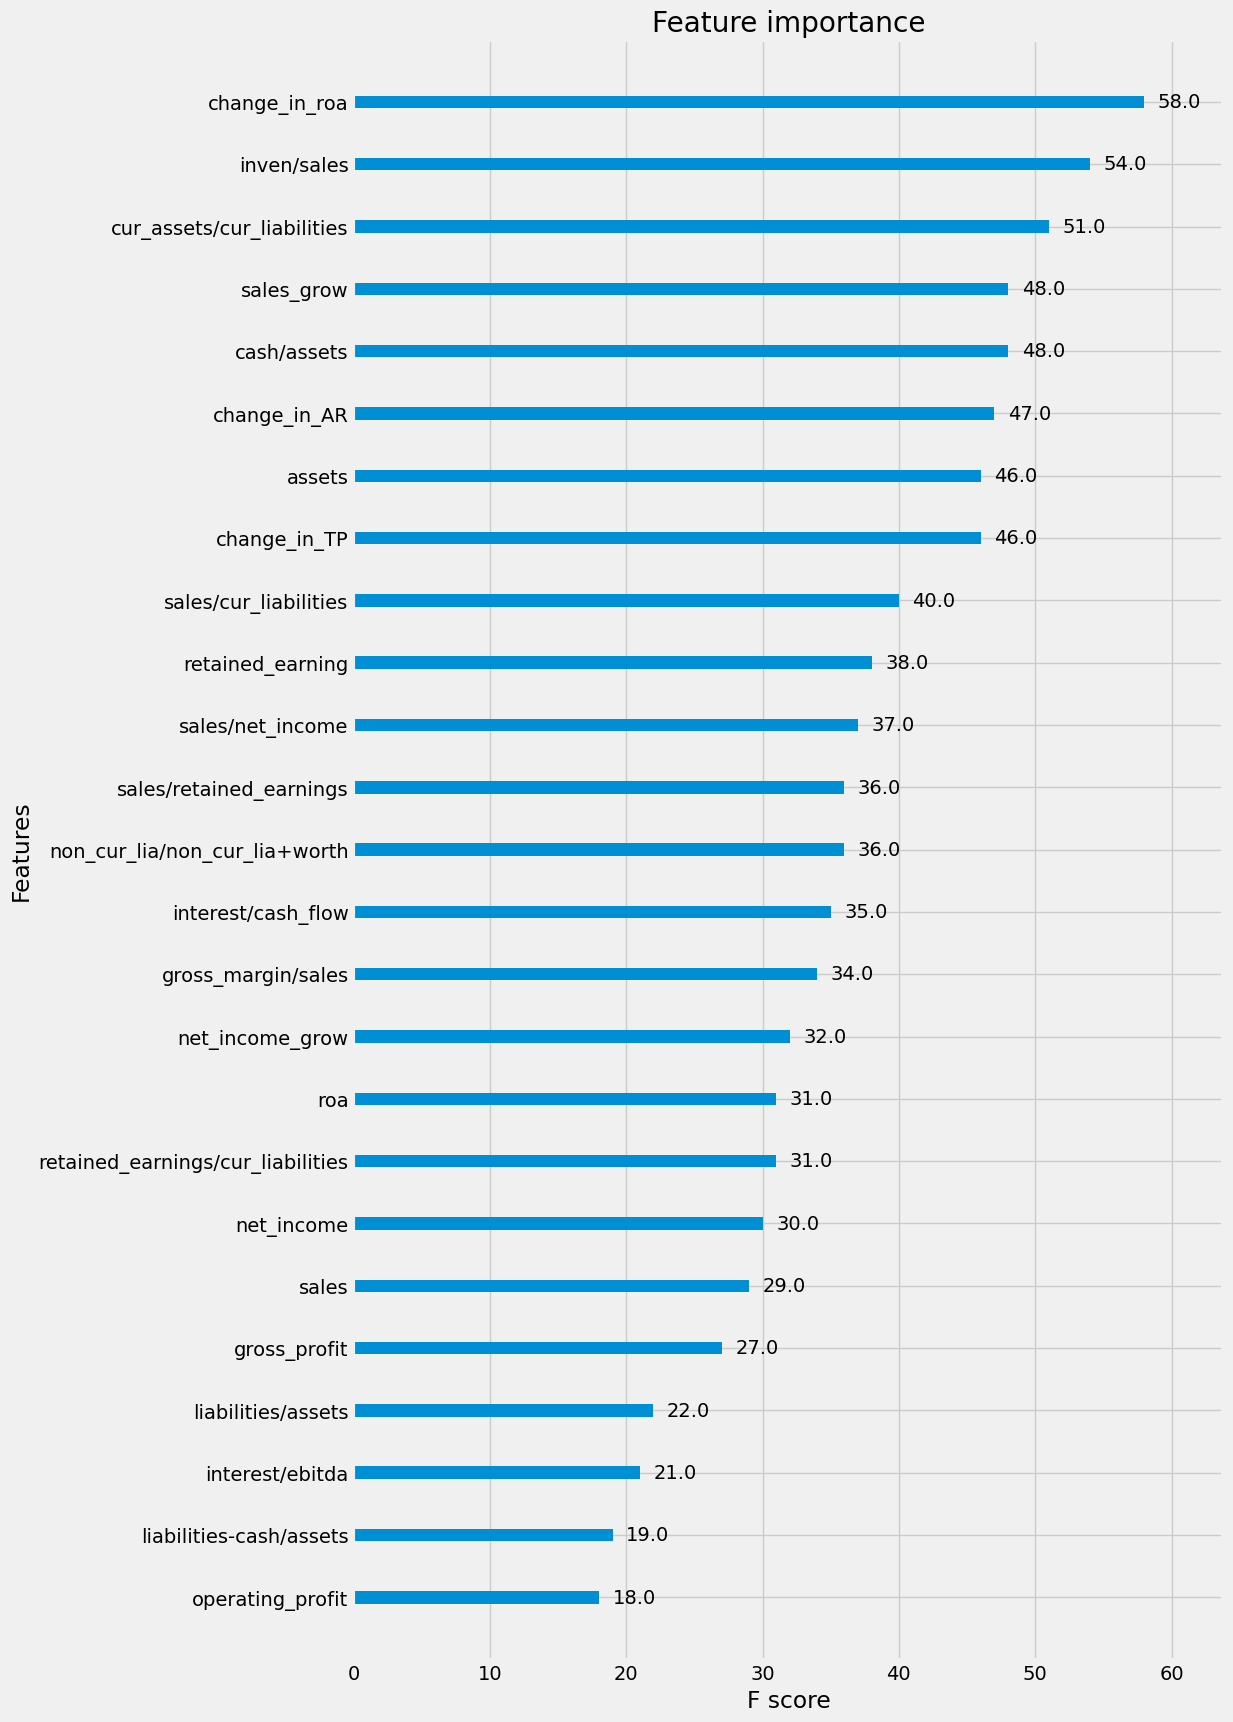

In [32]:
def shift_xgb_smltn(df, y_columns, start_col, end_col):
  df = df[df[y_columns]!=2]
  print(df.groupby(y_columns)[y_columns].count())

  X = df.loc[:,start_col:end_col]
  print(X.apply(lambda x: pd.isna(x).sum()))
  y = df[y_columns]
  result = xgb_smltn(X, y)

  return result

result_pnl0 = shift_xgb_smltn(pnl, 'fnc_rsn_unlst_year', 'cash/assets','retained_earning')
# result_pnl1 = shift_xgb_smltn(pnl, 'y_shift1', 'cash/assets','retained_earning')
# result_pnl2 = shift_xgb_smltn(pnl, 'y_shift2', 'cash/assets','retained_earning')
# result_pnl3 = shift_xgb_smltn(pnl, 'y_shift3', 'cash/assets','retained_earning')

In [29]:
def result_summary(result_df, title):
  print('[  '+title+'  ] \n')
  print("정확도:",accuracy_score(result_df['y_pred'], result_df['y_real']))
  result_count = pd.DataFrame(result_df.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
  print(result_df.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
  print('상장유지를 상장폐지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
  print('상장폐지를 상장유지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3], '\n')
  print('오답률:',round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
  print('오답률:',round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

result_summary(result_pnl0, 'Init result')
# result_summary(result_pnl1, 'shift1 result')
# result_summary(result_pnl2, 'shift2 result')
# result_summary(result_pnl3, 'shift3 result')

[  Init result  ] 

정확도: 0.9916732751784298
y_real  y_pred
0       0         17499
        1            17
1       0           130
        1             8
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 17 / 17516
상장폐지를 상장유지로 예측: 130 / 138 

오답률: 0.001
오답률: 0.942


In [ ]:
def All_shift_xgb_smltn(df, start_col, end_col):
  result_df0 = shift_xgb_smltn(df, 'fnc_rsn_unlst_year', start_col, end_col)
  result_df1 = shift_xgb_smltn(df, 'y_shift1', start_col, end_col)
  result_df2 = shift_xgb_smltn(df, 'y_shift2', start_col, end_col)
  result_df3 = shift_xgb_smltn(df, 'y_shift3', start_col, end_col)

  try:
    result_summary(result_df0, 'Init result')
  except:
    pass
  try:
    result_summary(result_df1, 'shift1 result')
  except:
    pass
  try:
    result_summary(result_df2, 'shift2 result')
  except:
    pass
  try:
    result_summary(result_df3, 'shift3 result')
  except:
    pass

In [ ]:
## 오버피팅 테스트

def overfitting_test(X, y):

  X_train_val,X_test,y_train_val,y_test= train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
  X_train,X_val,y_train,y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val, shuffle=True)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_train)
  y_pred_probs = xgb_model.predict_proba(X_train)[:,1]

  X_train['y_real'] = y_train
  X_train['y_pred'] = y_pre
  X_train['y_pred_probs'] = y_pred_probs

  print("정확도:",accuracy_score(y_pre, y_train))

  return X_train

# pnl_X = pnl.loc[:,'cash/assets':'retained_earning']
# pnl_y = pnl['fnc_rsn_unlst_year']
# result_overfit = overfitting_test(pnl_X, pnl_y)

In [ ]:
# result_summary(result_overfit, 'overfit result')

# #3. n년 기간동안 변화율 변수 추가

In [ ]:
def growth_rate(p0, p1):
  rate = (p1 - p0)/p0 #증가율 계산=(현재시점-이전시점)/(이전시점)
  return rate

In [ ]:
def train_growth_rate(df, contained_year, contained_columns): #마지막연도 재무정보 기준 n년 전

  ## X
  X = pd.DataFrame()

  for col in tqdm(df.loc[:,'cash/assets':contained_columns].columns):
    rate_list = []
    cor_list = []
    year_list = []
    y_list = []

    for cor in df['code_label'].unique():
      df_cor_col = df[df['code_label']==cor][col].values
      df_cor_y = df[df['code_label']==cor]['fnc_rsn_unlst_year']
      df_cor_year = df[df['code_label']==cor]['year']

      if len(df_cor_col) > contained_year:
        y_list.extend(list(df_cor_y))
        year_list.extend(list(df_cor_year))

        for idx in range(len(df_cor_col)):
          if idx < contained_year:
            p0 = np.nan
            p1 = df_cor_col[idx]
          else:
            p0 = df_cor_col[idx-contained_year]
            p1 = df_cor_col[idx]

          rate = growth_rate(p0, p1)
          rate_list.append(rate)
          cor_list.append(cor)

    X['fnc_rsn_unlst_year'] = y_list
    X['code_label'] = cor_list
    X['year'] = year_list
    X[col+'_'+'growth'+'_'+str(contained_year)] = rate_list
  X.replace([np.inf, -np.inf], np.nan, inplace=True)

  return X

In [ ]:
## pnl -> growth
train_growth1 = train_growth_rate(pnl, 1, 'retained_earning')
train_growth2 = train_growth_rate(pnl, 2, 'retained_earning')
train_growth3 = train_growth_rate(pnl, 3, 'retained_earning')
train_growth4 = train_growth_rate(pnl, 4, 'retained_earning')

100%|██████████| 25/25 [01:14<00:00,  2.98s/it]


In [ ]:
## pnl과 growth(n=1) merge
def merge_pnl_grwth(df_pnl, df_growth):
  union_pnl_growth = df_pnl.merge(df_growth.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
  # union_pnl_growth = union_pnl_growth[list(union_pnl_growth.loc[:,:'retained_earning'].columns) + list(union_pnl_growth.loc[:,'cash/assets_growth':].columns) + list(df_pnl.loc[:,'fnc_rsn_unlst_year':'y_shift3'].columns)]
  union_pnl_growth.replace([np.inf, -np.inf], np.nan, inplace=True)
  print(union_pnl_growth.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count()) #inf값 삭제
  return union_pnl_growth

# uni_pnl_growth1 = merge_pnl_grwth(pnl, train_growth1)
# uni_pnl_growth2 = merge_pnl_grwth(pnl, train_growth2)
# uni_pnl_growth3 = merge_pnl_grwth(pnl, train_growth3)
# uni_pnl_growth4 = merge_pnl_grwth(pnl, train_growth4)

pnl_growth1234 = merge_pnl_grwth(pnl, train_growth1)
pnl_growth1234 = merge_pnl_grwth(pnl_growth1234, train_growth2)
pnl_growth1234 = merge_pnl_grwth(pnl_growth1234, train_growth3)
pnl_growth1234 = merge_pnl_grwth(pnl_growth1234, train_growth4)

fnc_rsn_unlst_year
0    54108
1      605
Name: fnc_rsn_unlst_year, dtype: int64
fnc_rsn_unlst_year
0    54079
1      600
Name: fnc_rsn_unlst_year, dtype: int64
fnc_rsn_unlst_year
0    53975
1      593
Name: fnc_rsn_unlst_year, dtype: int64
fnc_rsn_unlst_year
0    53773
1      579
Name: fnc_rsn_unlst_year, dtype: int64


In [ ]:
y_cols = pnl_growth1234[['fnc_rsn_unlst_year',	'y_shift1',	'y_shift2',	'y_shift3']]
pnl_growth1234 = pnl_growth1234.drop(['fnc_rsn_unlst_year',	'y_shift1',	'y_shift2',	'y_shift3'], axis=1)
pnl_growth1234 = pd.concat([pnl_growth1234,y_cols], axis=1)
pnl_growth1234

,year,code_label,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning,cash/assets_growth_1,liabilities/assets_growth_1,liabilities-cash/assets_growth_1,sales/cur_liabilities_growth_1,cur_assets/cur_liabilities_growth_1,retained_earnings/cur_liabilities_growth_1,non_cur_lia/non_cur_lia+worth_growth_1,interest/cash_flow_growth_1,interest/ebitda_growth_1,inven/sales_growth_1,sales/net_income_growth_1,gross_margin/sales_growth_1,sales/retained_earnings_growth_1,change_in_roa_growth_1,change_in_AR_growth_1,change_in_TP_growth_1,assets_growth_1,sales_growth_1,roa_growth_1,sales_grow_growth_1,net_income_growth_1,net_income_grow_growth_1,gross_profit_growth_1,...,cur_assets/cur_liabilities_growth_3,retained_earnings/cur_liabilities_growth_3,non_cur_lia/non_cur_lia+worth_growth_3,interest/cash_flow_growth_3,interest/ebitda_growth_3,inven/sales_growth_3,sales/net_income_growth_3,gross_margin/sales_growth_3,sales/retained_earnings_growth_3,change_in_roa_growth_3,change_in_AR_growth_3,change_in_TP_growth_3,assets_growth_3,sales_growth_3,roa_growth_3,sales_grow_growth_3,net_income_growth_3,net_income_grow_growth_3,gross_profit_growth_3,operating_profit_growth_3,retained_earning_growth_3,cash/assets_growth_4,liabilities/assets_growth_4,liabilities-cash/assets_growth_4,sales/cur_liabilities_growth_4,cur_assets/cur_liabilities_growth_4,retained_earnings/cur_liabilities_growth_4,non_cur_lia/non_cur_lia+worth_growth_4,interest/cash_flow_growth_4,interest/ebitda_growth_4,inven/sales_growth_4,sales/net_income_growth_4,gross_margin/sales_growth_4,sales/retained_earnings_growth_4,change_in_roa_growth_4,change_in_AR_growth_4,change_in_TP_growth_4,assets_growth_4,sales_growth_4,roa_growth_4,sales_grow_growth_4,net_income_growth_4,net_income_grow_growth_4,gross_profit_growth_4,operating_profit_growth_4,retained_earning_growth_4,fnc_rsn_unlst_year,y_shift1,y_shift2,y_shift3
0,1990,5930,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,-53.930000,3.677766e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,1991,5930,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,-6.010000,4.030919e+08,-0.559457,0.024559,0.044219,-0.310709,-0.219571,-0.347920,-0.030507,-1.000000,-1.000000,0.089481,0.232701,0.174407,0.057064,-0.504637,-0.422686,2.033675,0.368385,0.158567,-0.319048,0.258730,-0.060139,-0.888559,0.360630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,1992,5930,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,5.550000,4.395800e+08,1.270775,-0.007076,-0.025224,0.076502,-0.042972,0.005506,0.008045,NaN,NaN,-0.186417,0.106105,-0.001733,0.070607,-0.539714,-1.622316,-1.812755,0.139555,0.167519,-0.146853,0.056116,0.055523,-1.923461,0.165496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
All_shift_xgb_smltn(pnl_growth1234, 'cash/assets','retained_earning_growth_4')
# result_summary(result_pnl001, 'Init result')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
result_pnl001 = shift_xgb_smltn(uni_pnl_growth1, 'fnc_rsn_unlst_year', 'cash/assets','retained_earning_growth')
result_pnl002 = shift_xgb_smltn(uni_pnl_growth2, 'fnc_rsn_unlst_year', 'cash/assets','retained_earning_growth')
result_pnl003 = shift_xgb_smltn(uni_pnl_growth3, 'fnc_rsn_unlst_year', 'cash/assets','retained_earning_growth')
result_pnl004 = shift_xgb_smltn(uni_pnl_growth4, 'fnc_rsn_unlst_year', 'cash/assets','retained_earning_growth')

result_pnl011 = shift_xgb_smltn(uni_pnl_growth1, 'y_shift1', 'cash/assets','retained_earning_growth')
result_pnl012 = shift_xgb_smltn(uni_pnl_growth2, 'y_shift1', 'cash/assets','retained_earning_growth')
result_pnl013 = shift_xgb_smltn(uni_pnl_growth3, 'y_shift1', 'cash/assets','retained_earning_growth')
result_pnl014 = shift_xgb_smltn(uni_pnl_growth4, 'y_shift1', 'cash/assets','retained_earning_growth')

result_pnl021 = shift_xgb_smltn(uni_pnl_growth1, 'y_shift2', 'cash/assets','retained_earning_growth')
result_pnl022 = shift_xgb_smltn(uni_pnl_growth2, 'y_shift2', 'cash/assets','retained_earning_growth')
result_pnl023 = shift_xgb_smltn(uni_pnl_growth3, 'y_shift2', 'cash/assets','retained_earning_growth')
result_pnl024 = shift_xgb_smltn(uni_pnl_growth4, 'y_shift2', 'cash/assets','retained_earning_growth')

result_pnl031 = shift_xgb_smltn(uni_pnl_growth1, 'y_shift3', 'cash/assets','retained_earning_growth')
result_pnl032 = shift_xgb_smltn(uni_pnl_growth2, 'y_shift3', 'cash/assets','retained_earning_growth')
result_pnl033 = shift_xgb_smltn(uni_pnl_growth3, 'y_shift3', 'cash/assets','retained_earning_growth')
result_pnl034 = shift_xgb_smltn(uni_pnl_growth4, 'y_shift3', 'cash/assets','retained_earning_growth')

In [ ]:
result_summary(result_pnl001, 'Init result')
result_summary(result_pnl002, 'Init result')
result_summary(result_pnl003, 'Init result')
result_summary(result_pnl004, 'Init result')

# result_summary(result_pnl011, 'y_shift1')
# result_summary(result_pnl012, 'y_shift1')
# result_summary(result_pnl013, 'y_shift1')
# result_summary(result_pnl014, 'y_shift1')

# result_summary(result_pnl021, 'y_shift2')
# result_summary(result_pnl022, 'y_shift2')
# result_summary(result_pnl023, 'y_shift2')
# result_summary(result_pnl024, 'y_shift2')

# result_summary(result_pnl031, 'y_shift3')
# result_summary(result_pnl032, 'y_shift3')
# result_summary(result_pnl033, 'y_shift3')
# result_summary(result_pnl034, 'y_shift3')

[  Init result  ] 

정확도: 0.9880288769076122
y_real  y_pred
0       0         10806
        1            16
1       0           115
        1             6
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 16 / 10822
상장폐지를 상장유지로 예측: 115 / 121 

오답률: 0.0015
오답률: 0.9504
[  Init result  ] 

정확도: 0.9885698610095098
y_real  y_pred
0       0         10804
        1            12
1       0           113
        1             7
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 12 / 10816
상장폐지를 상장유지로 예측: 113 / 120 

오답률: 0.0011
오답률: 0.9417
[  Init result  ] 

정확도: 0.9890049477735019
y_real  y_pred
0       0         10785
        1            10
1       0           110
        1             9
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 10 / 10795
상장폐지를 상장유지로 예측: 110 / 119 

오답률: 0.0009
오답률: 0.9244
[  Init result  ] 

정확도: 0.9902492870941035
y_real  y_pred
0       0         10750
        1             5
1       0           101
        1            15
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 5 / 10755
상

## (1) pnl + growth, drop

fnc_rsn_unlst_year
0    54108
1      605
Name: fnc_rsn_unlst_year, dtype: int64
[0]	validation_0-logloss:0.44774
[1]	validation_0-logloss:0.31243
[2]	validation_0-logloss:0.22779
[3]	validation_0-logloss:0.17176
[4]	validation_0-logloss:0.13352
[5]	validation_0-logloss:0.10685
[6]	validation_0-logloss:0.08791
[7]	validation_0-logloss:0.07459
[8]	validation_0-logloss:0.06517
[9]	validation_0-logloss:0.05830
[10]	validation_0-logloss:0.05349
[11]	validation_0-logloss:0.05027
[12]	validation_0-logloss:0.04775
[13]	validation_0-logloss:0.04610
[14]	validation_0-logloss:0.04497
[15]	validation_0-logloss:0.04427
[16]	validation_0-logloss:0.04366
[17]	validation_0-logloss:0.04331
[18]	validation_0-logloss:0.04300
[19]	validation_0-logloss:0.04286
[20]	validation_0-logloss:0.04283
[21]	validation_0-logloss:0.04269
[22]	validation_0-logloss:0.04264
[23]	validation_0-logloss:0.04256
[24]	validation_0-logloss:0.04262
[25]	validation_0-logloss:0.04267
[26]	validation_0-logloss:0.04255
[27]	validat

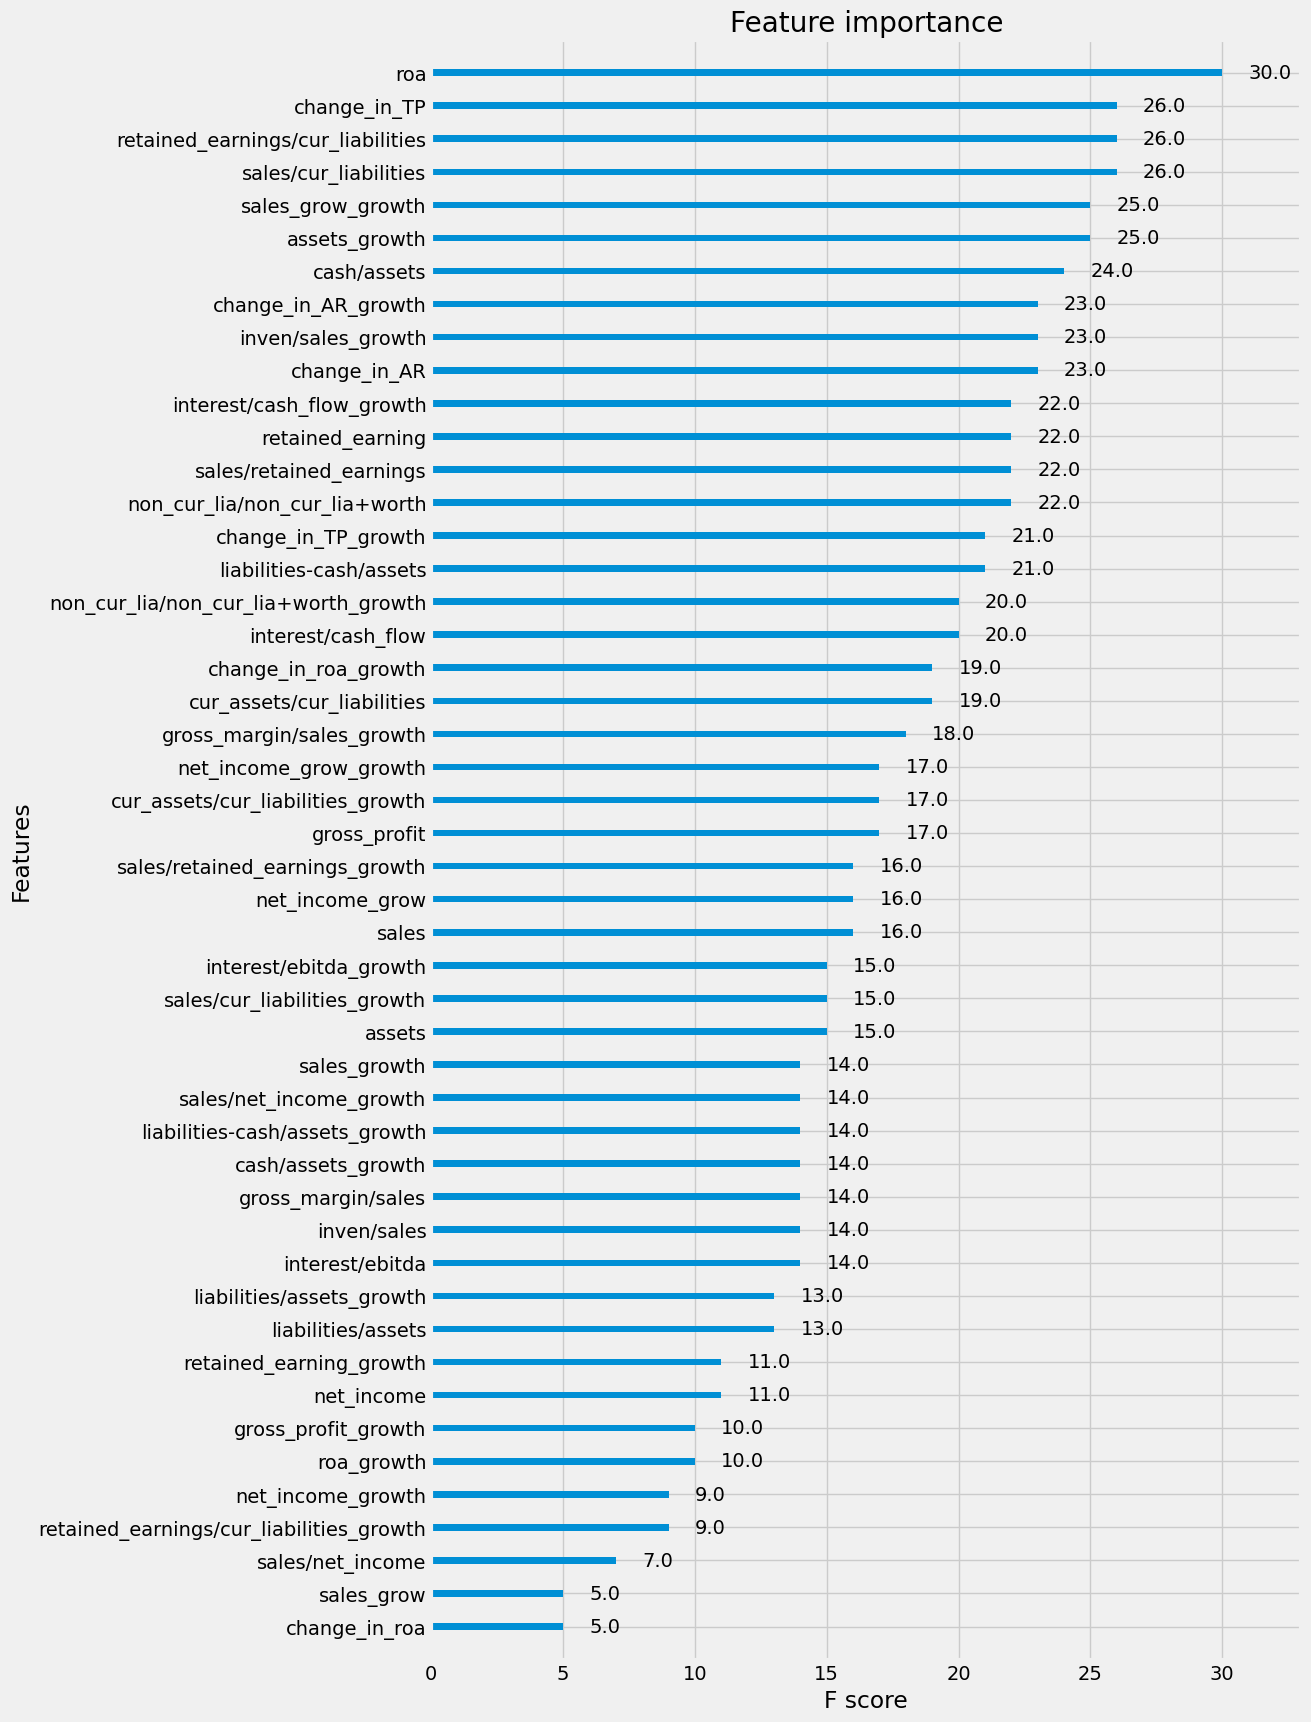

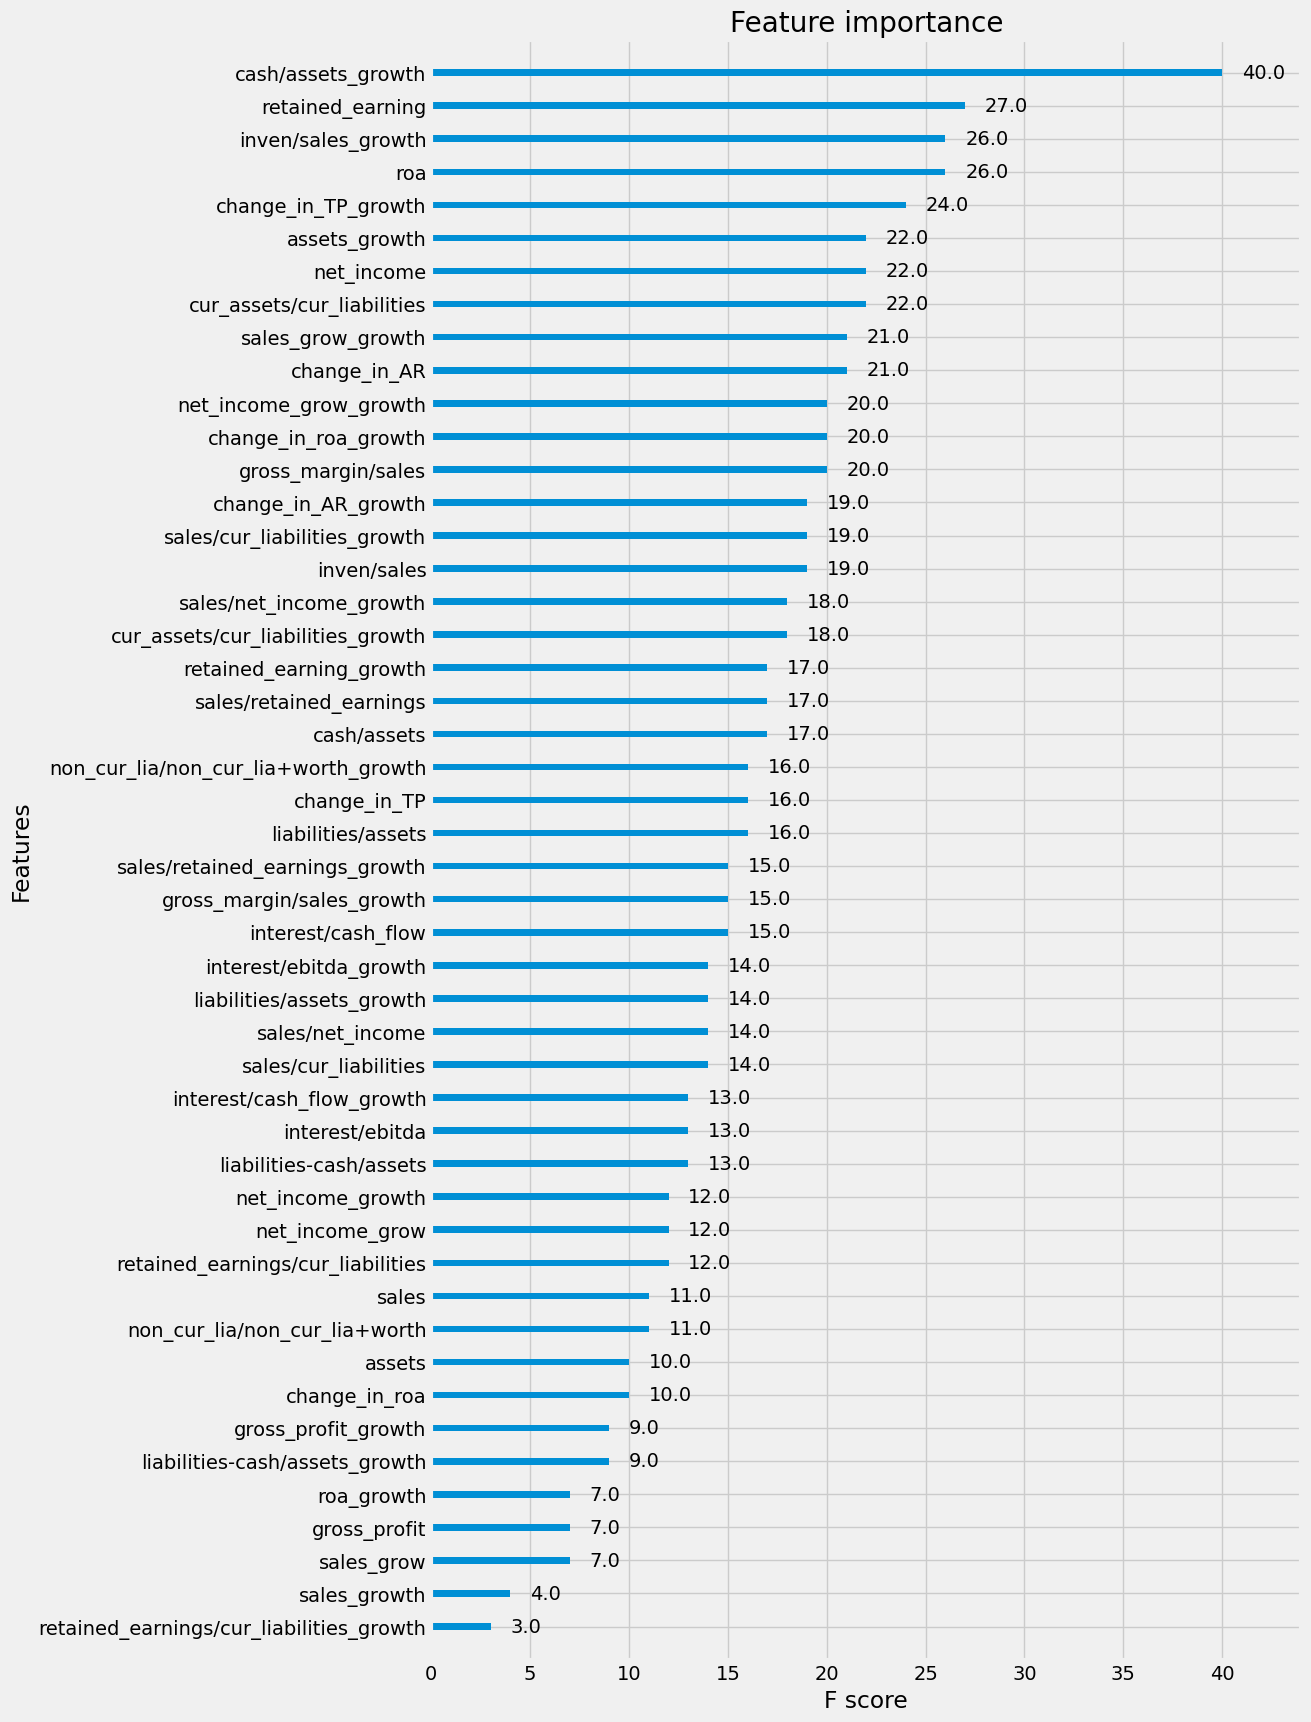

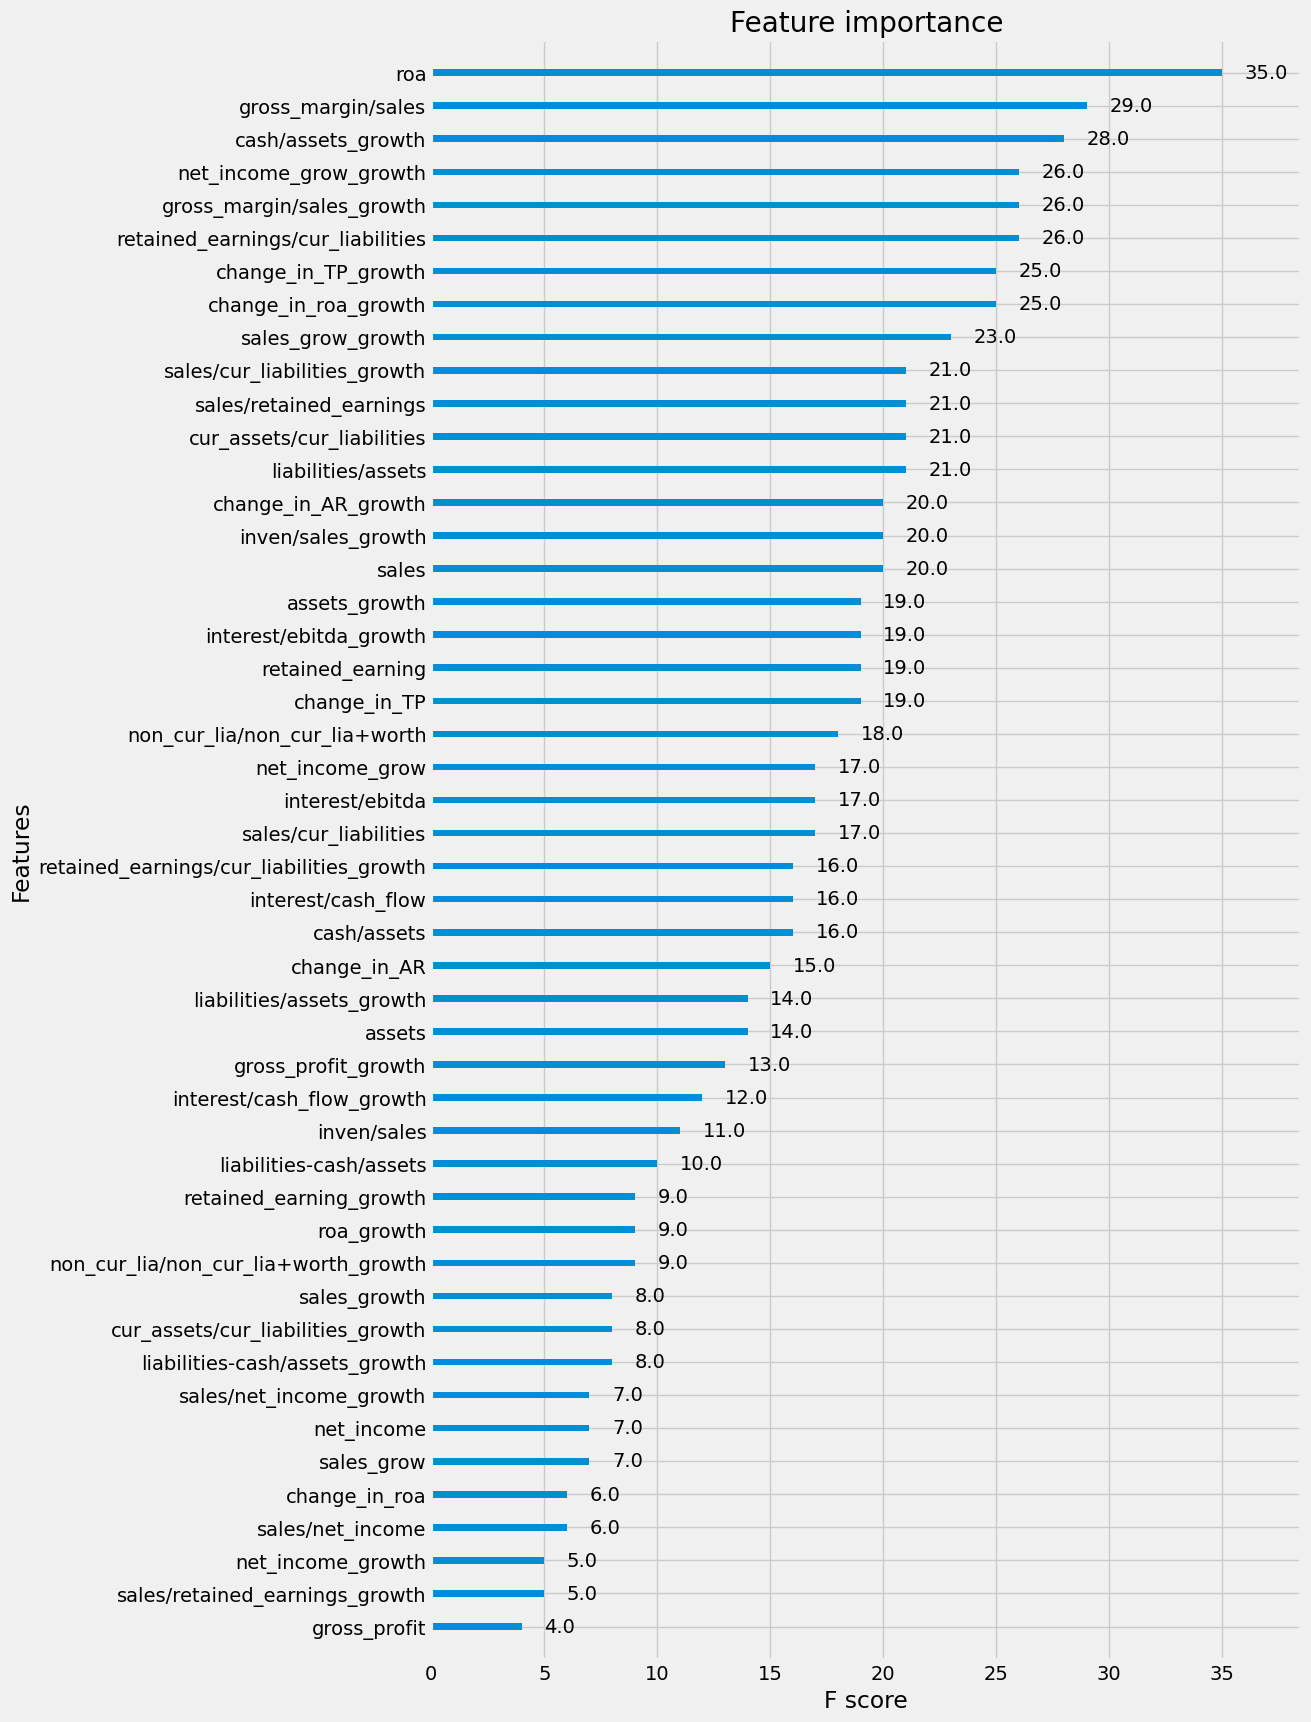

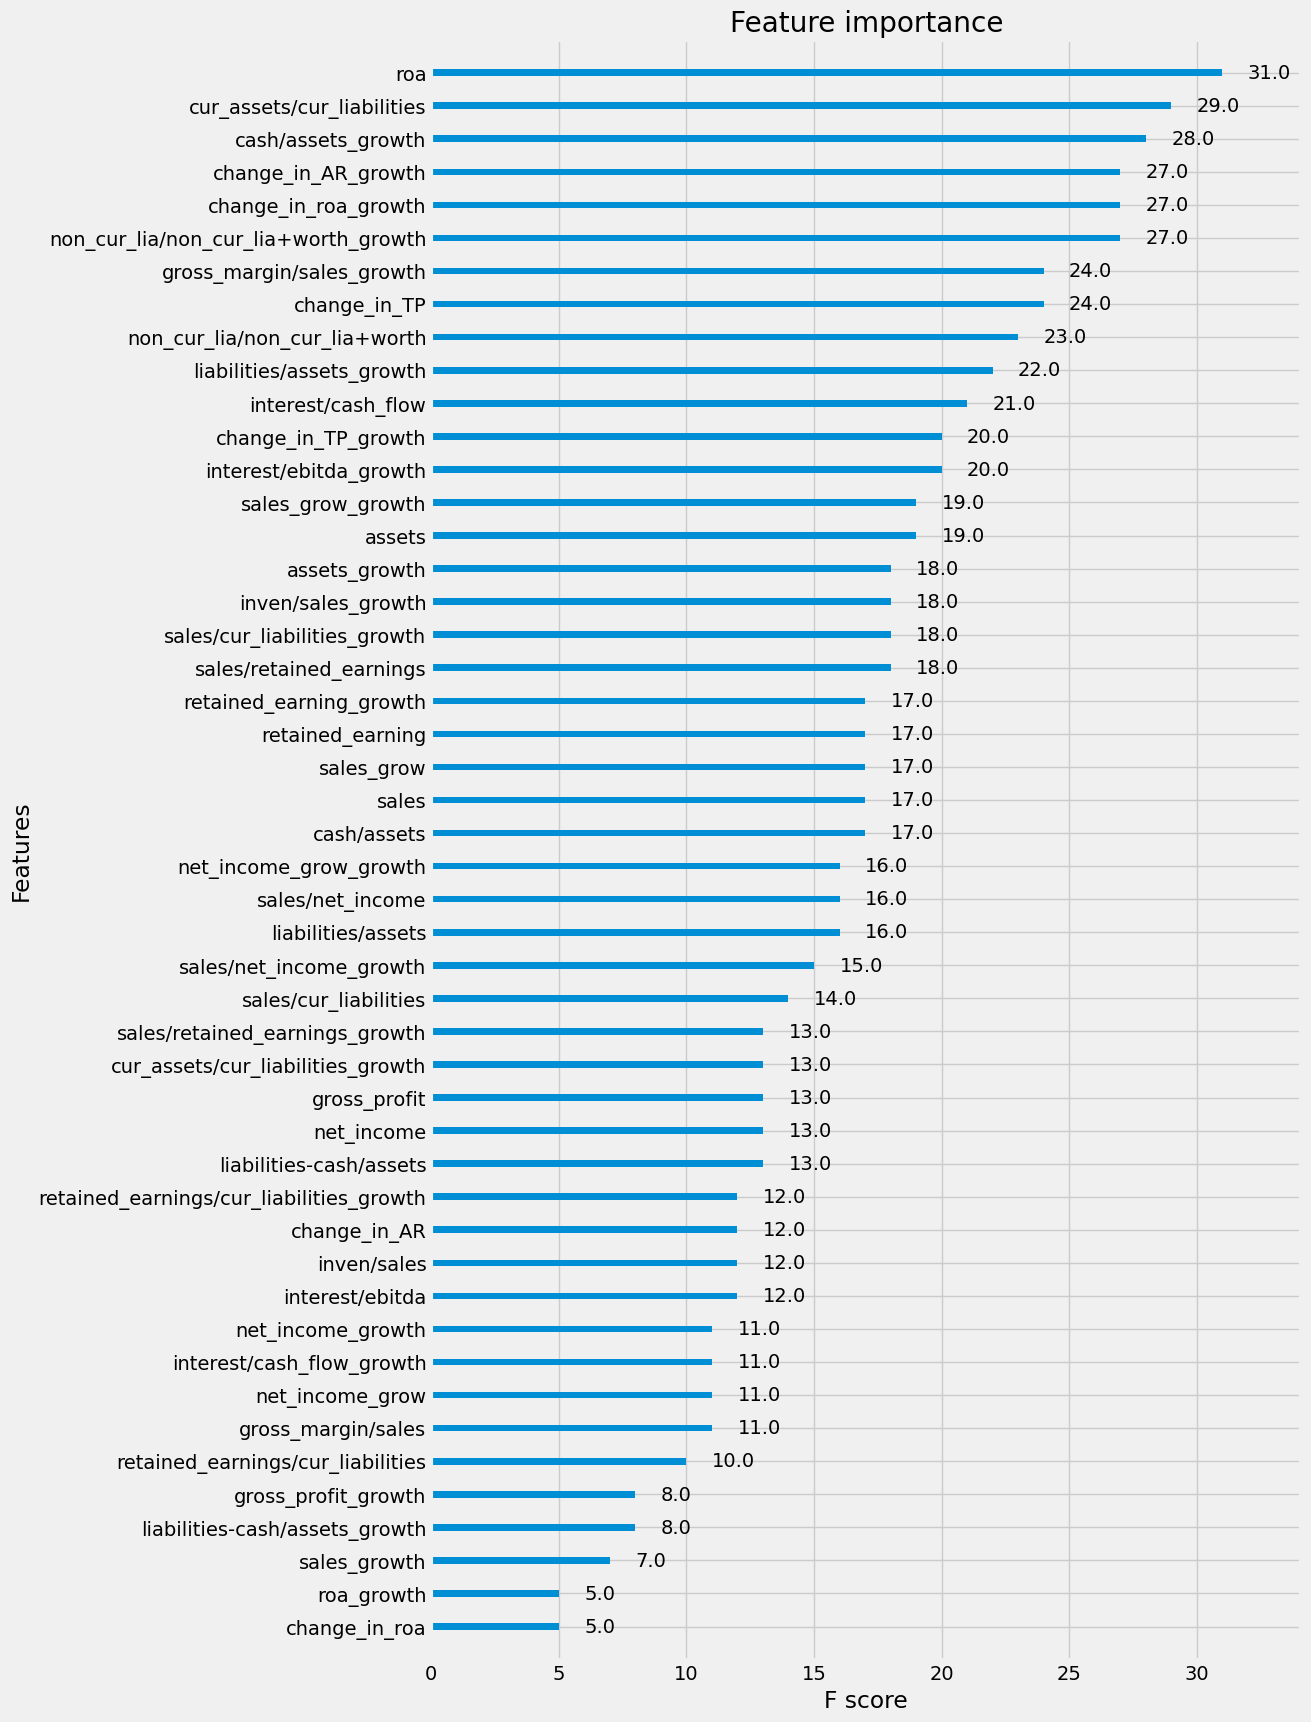

In [ ]:
## union1: pnl + growth

# result_union1_0 = shift_xgb_smltn(union_pnl_growth, 'fnc_rsn_unlst_year', 'cash/assets','retained_earning')
# result_union1_1 = shift_xgb_smltn(union_pnl_growth, 'y_shift1', 'cash/assets','retained_earning')
# result_union1_2 = shift_xgb_smltn(union_pnl_growth, 'y_shift2', 'cash/assets','retained_earning')
# result_union1_3 = shift_xgb_smltn(union_pnl_growth, 'y_shift3', 'cash/assets','retained_earning')

# result_summary(result_union1_0, 'Init result')
# result_summary(result_union1_1, 'shift1 result')
# # result_summary(result_pnl_growth2, 'shift2 result')
# # result_summary(result_pnl_growth3, 'shift3 result')

All_shift_xgb_smltn(uni_pnl_growth1, 'cash/assets','retained_earning_growth')

In [ ]:
 ## union2: pnl + growth.drop(Nan=subset_growth)
# union_train2 = uni_pnl_growth1.dropna(axis=0, how='all', subset=uni_pnl_growth1.loc[:,'cash/assets_growth':'retained_earning_growth'].columns)
# print(union_train2.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())
# # union_train2.apply(lambda x: pd.isna(x).sum())

# All_shift_xgb_smltn(union_train2, 'cash/assets','retained_earning_growth')

In [ ]:
## union3: pnl + growth.drop(Nan, how='all')
# union_train3 = uni_pnl_growth1.dropna(axis=0)
# print(union_train3.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

# All_shift_xgb_smltn(union_train3, 'cash/assets','retained_earning_growth')

## (2) growth(n=1), growth(n=1), growth(n=1)

In [ ]:
def train_row_to_col(df, contained_year, contained_columns):

  ## X
  X = pd.DataFrame()

  for cor in tqdm(df['code_label'].unique()):
    df_cor = df[df['code_label']==cor].reset_index(drop=True)
    df_cor_y = df_cor['fnc_rsn_unlst_year']
    df_cor_y1 = df_cor['y_shift1']
    df_cor_y2 = df_cor['y_shift2']
    df_cor_y3 = df_cor['y_shift3']

    if len(df_cor) >= contained_year: #contained_year보다 영업하지 않은 기업 제외
      for idx, y in enumerate(zip(df_cor_y, df_cor_y1, df_cor_y2, df_cor_y3)):
        df_cor = df.loc[idx-contained_year:idx, 'cash/assets':contained_columns]

        if len(df_cor) < contained_year+1: #contained_year이 없는 시점인 경우 ex.2년전+현재idx
          nan_before = pd.DataFrame(columns=df.loc[:,'cash/assets':contained_columns].columns, index=range(contained_year-idx))
          df_cor = pd.concat([nan_before, df_cor], axis=0).reset_index(drop=True)

        cor_result = pd.DataFrame()
        for row in df_cor.index:
          row_df = df_cor.loc[[row]].reset_index(drop=True)
          cor_result = pd.concat([cor_result, row_df], axis=1)

        cor_result.columns = [col+'_'+str(num) for num in range(len(df_cor)) for col in df_cor.columns]
        cor_result['fnc_rsn_unlst_year'] = y[0]
        cor_result['y_shift1'] = y[1]
        cor_result['y_shift2'] = y[2]
        cor_result['y_shift3'] = y[3]
        cor_result['code_label'] = cor

        X = pd.concat([X, cor_result], ignore_index=True)

    else:
      pass

  return X

In [ ]:
trn_grwth1 = train_row_to_col(uni_pnl_growth1, 1, 'retained_earning_growth') #1년전 자료까지
trn_grwth2 = train_row_to_col(uni_pnl_growth2, 1, 'retained_earning_growth') #1년전 자료까지
# trn_grwth3 = train_row_to_col(uni_pnl_growth3, 1, 'retained_earning_growth') #1년전 자료까지
# trn_grwth4 = train_row_to_col(uni_pnl_growth4, 1, 'retained_earning_growth') #1년전 자료까지

trn_grwth1_2 = train_row_to_col(uni_pnl_growth1, 2, 'retained_earning_growth') #2년전 자료까지
trn_grwth2_2 = train_row_to_col(uni_pnl_growth2, 2, 'retained_earning_growth') #2년전 자료까지
# trn_grwth3_2 = train_row_to_col(uni_pnl_growth3, 2, 'retained_earning_growth') #2년전 자료까지
# trn_grwth4_2 = train_row_to_col(uni_pnl_growth4, 2, 'retained_earning_growth') #2년전 자료까지

In [ ]:
trn_grwth2.loc[:,'retained_earning_0':]

In [ ]:
trn_grwth2

In [ ]:
trn_grwth2['non_cur_lia/non_cur_lia+worth_1']

### growth(1년전 자료까지)

In [ ]:
All_shift_xgb_smltn(trn_grwth1, 'cash/assets_0', 'retained_earning_growth_1')

In [ ]:
All_shift_xgb_smltn(trn_grwth2, 'cash/assets_0', 'retained_earning_growth_1')

In [ ]:
# All_shift_xgb_smltn(trn_grwth3, 'cash/assets_0', 'retained_earning_growth_1')

In [ ]:
# All_shift_xgb_smltn(trn_grwth4, 'cash/assets_0', 'retained_earning_growth_1')

### growth(2년전 자료까지)

In [ ]:
All_shift_xgb_smltn(trn_grwth1_2, 'cash/assets_0', 'retained_earning_growth_2')

NameError: ignored

In [ ]:
 All_shift_xgb_smltn(trn_grwth2_2, 'cash/assets_0', 'retained_earning_growth_2')

In [ ]:
# All_shift_xgb_smltn(trn_grwth3_2, 'cash/assets_0', 'retained_earning_growth_2')

In [ ]:
# All_shift_xgb_smltn(trn_grwth4_2, 'cash/assets_0', 'retained_earning_growth_2')

## (3) growth(n=1) + growth(n=2) + growth(n=3) + growth(n=4)

In [ ]:
from itertools import chain

## pnl과 growth(n=1) merge
def merge_pnl_grwth(df_pnl, df_growth):
  union_pnl_growth = df_pnl.merge(df_growth.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
  # union_pnl_growth = union_pnl_growth[list(union_pnl_growth.loc[:,:'retained_earning'].columns) + list(union_pnl_growth.loc[:,'cash/assets_growth':].columns) + list(union_pnl_growth.loc[:,'fnc_rsn_unlst_year':'y_shift3'].columns)]
  union_pnl_growth.replace([np.inf, -np.inf], np.nan, inplace=True)
  print(union_pnl_growth.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count()) #inf값 삭제
  return union_pnl_growth

uni_pnl_growth12 = merge_pnl_grwth(uni_pnl_growth1, train_growth2)
# uni_pnl_growth123 = merge_pnl_grwth(uni_pnl_growth12, train_growth3)
# uni_pnl_growth1234 = merge_pnl_grwth(uni_pnl_growth123, uni_pnl_growth4)

fnc_rsn_unlst_year
0    54079
1      600
Name: fnc_rsn_unlst_year, dtype: int64


In [ ]:
uni_pnl_growth12[['year', 'code_label', 'cash/assets', 'liabilities/assets',
       'liabilities-cash/assets', 'sales/cur_liabilities',
       'cur_assets/cur_liabilities', 'retained_earnings/cur_liabilities',
       'non_cur_lia/non_cur_lia+worth', 'interest/cash_flow',
       'interest/ebitda', 'inven/sales', 'sales/net_income',
       'gross_margin/sales', 'sales/retained_earnings', 'change_in_roa',
       'change_in_AR', 'change_in_TP', 'assets', 'sales', 'roa', 'sales_grow',
       'net_income', 'net_income_grow', 'gross_profit', 'operating_profit',
       'retained_earning']]

,year,code_label,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning
0,1990,5930,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,-53.930000,3.677766e+08
1,1991,5930,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,-6.010000,4.030919e+08
2,1992,5930,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,5.550000,4.395800e+08
3,1993,5930,0.033530,0.793795,0.760265,2.495139,0.815311,0.162677,0.649281,0.000000,0.000000,0.124302,113.547603,0.308030,15.337989,-0.147541,-0.127702,-0.419701,8.447099e+09,8.684668e+09,1.04,42.31,7.648482e+07,5.590000,2.675142e+09,5.590000,5.662195e+08
4,1994,5930,0.022999,0.692778,0.669779,3.189266,1.128719,0.412265,0.501214,0.000000,0.000000,0.098240,11.736092,0.375319,7.735951,9.682692,0.278744,-0.079209,9.603379e+09,1.176292e+10,11.11,35.44,1.002286e+09,1210.440000,4.414842e+09,1210.440000,1.520553e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54674,2017,950180,0.611887,0.168936,-0.442952,4.380337,5.477438,2.218058,0.005800,0.020936,0.018697,0.000820,1.830197,0.890897,1.974852,NaN,NaN,NaN,7.581997e+07,5.449621e+07,NaN,NaN,2.977615e+07,NaN,4.855051e+07,NaN,2.759508e+07
54675,2018,950180,0.527099,0.165288,-0.361812,4.341584,6.356767,3.357695,0.019078,0.000000,0.000000,0.028286,2.734232,0.872833,1.293025,NaN,0.027818,0.856271,1.049511e+08,6.791689e+07,27.48,24.63,2.483948e+07,-16.580000,5.928011e+07,-16.580000,5.252557e+07
54676,2019,950180,0.817917,0.054197,-0.763720,7.171777,21.456253,6.256272,0.010316,0.000000,0.000000,0.006349,3.274688,0.792945,1.146334,-0.467249,-0.211815,0.047309,3.209885e+08,1.020694e+08,14.64,50.29,3.116920e+07,25.480000,8.093543e+07,25.480000,8.903985e+07
54677,2020,950180,0.600422,0.065299,-0.535123,4.686278,17.116893,6.287657,0.014456,0.006268,0.005792,0.009289,3.796404,0.846271,0.745314,-0.542350,-0.183378,0.318245,3.557298e+08,8.600066e+07,6.70,-15.74,2.265319e+07,-27.320000,7.277991e+07,-27.320000,1.153885e+08


fnc_rsn_unlst_year
0    54079
1      600
Name: fnc_rsn_unlst_year, dtype: int64
[0]	validation_0-logloss:0.44769
[1]	validation_0-logloss:0.31241
[2]	validation_0-logloss:0.22790
[3]	validation_0-logloss:0.17177
[4]	validation_0-logloss:0.13333
[5]	validation_0-logloss:0.10654
[6]	validation_0-logloss:0.08783
[7]	validation_0-logloss:0.07442
[8]	validation_0-logloss:0.06469
[9]	validation_0-logloss:0.05814
[10]	validation_0-logloss:0.05311
[11]	validation_0-logloss:0.04979
[12]	validation_0-logloss:0.04735
[13]	validation_0-logloss:0.04557
[14]	validation_0-logloss:0.04435
[15]	validation_0-logloss:0.04349
[16]	validation_0-logloss:0.04277
[17]	validation_0-logloss:0.04218
[18]	validation_0-logloss:0.04193
[19]	validation_0-logloss:0.04140
[20]	validation_0-logloss:0.04113
[21]	validation_0-logloss:0.04101
[22]	validation_0-logloss:0.04076
[23]	validation_0-logloss:0.04045
[24]	validation_0-logloss:0.04035
[25]	validation_0-logloss:0.04033
[26]	validation_0-logloss:0.04064
[27]	validat

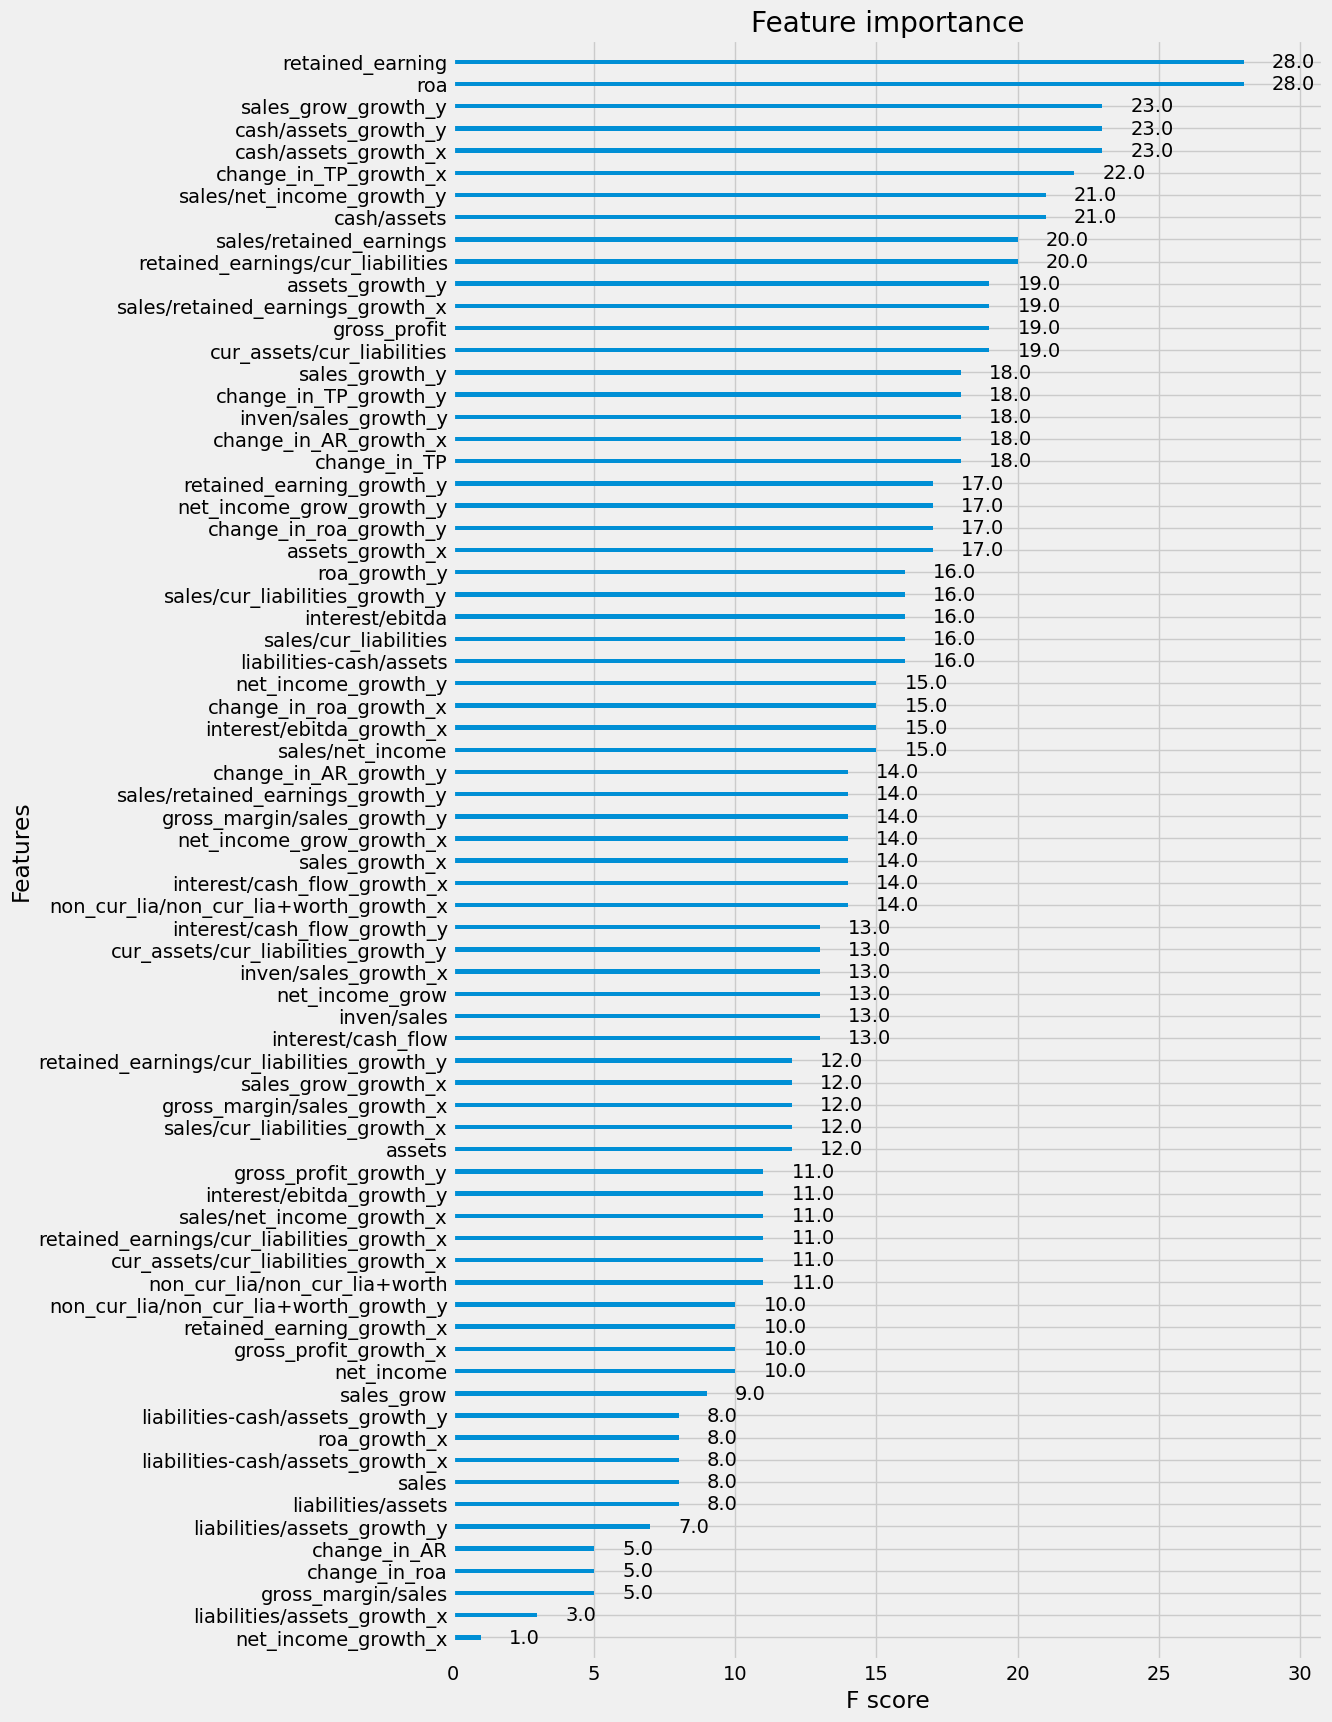

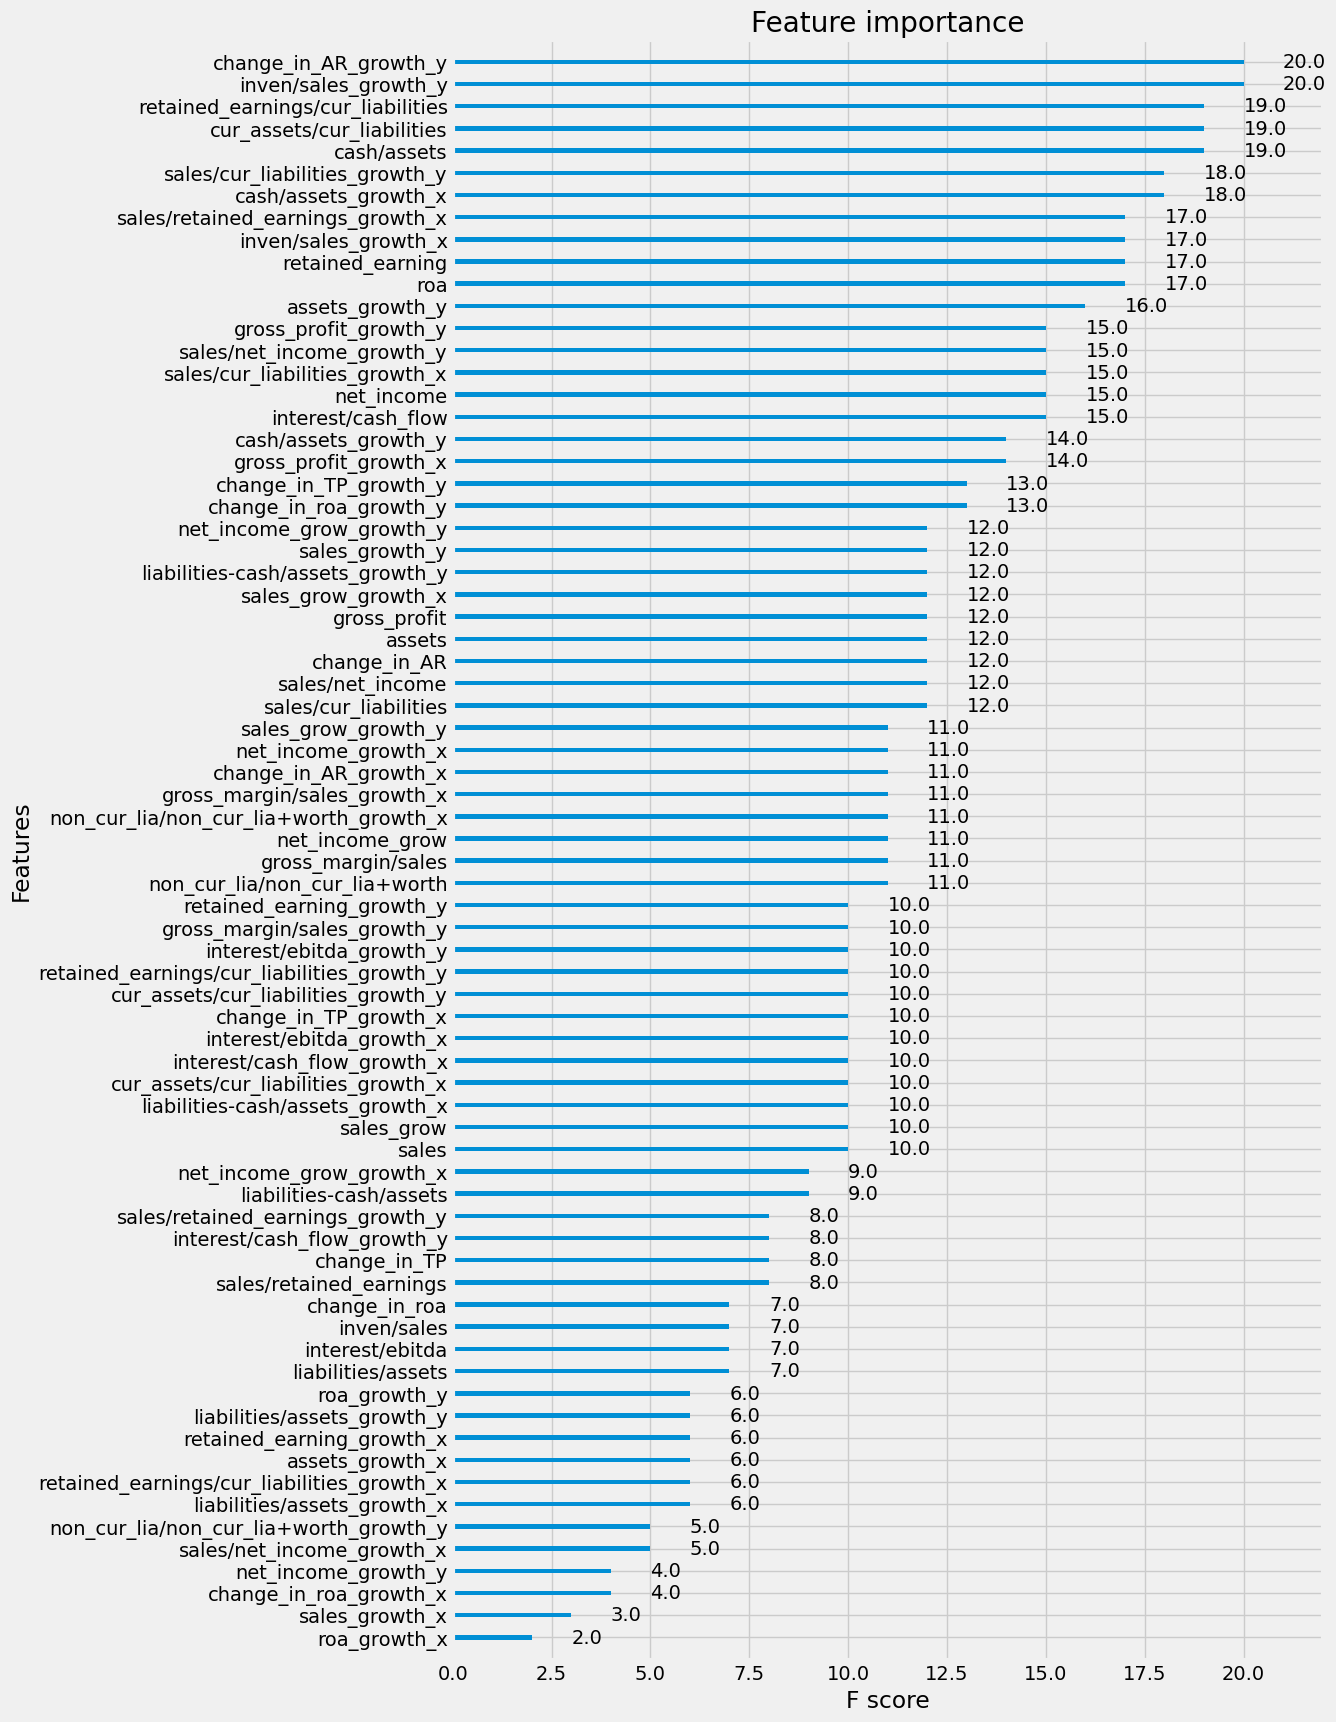

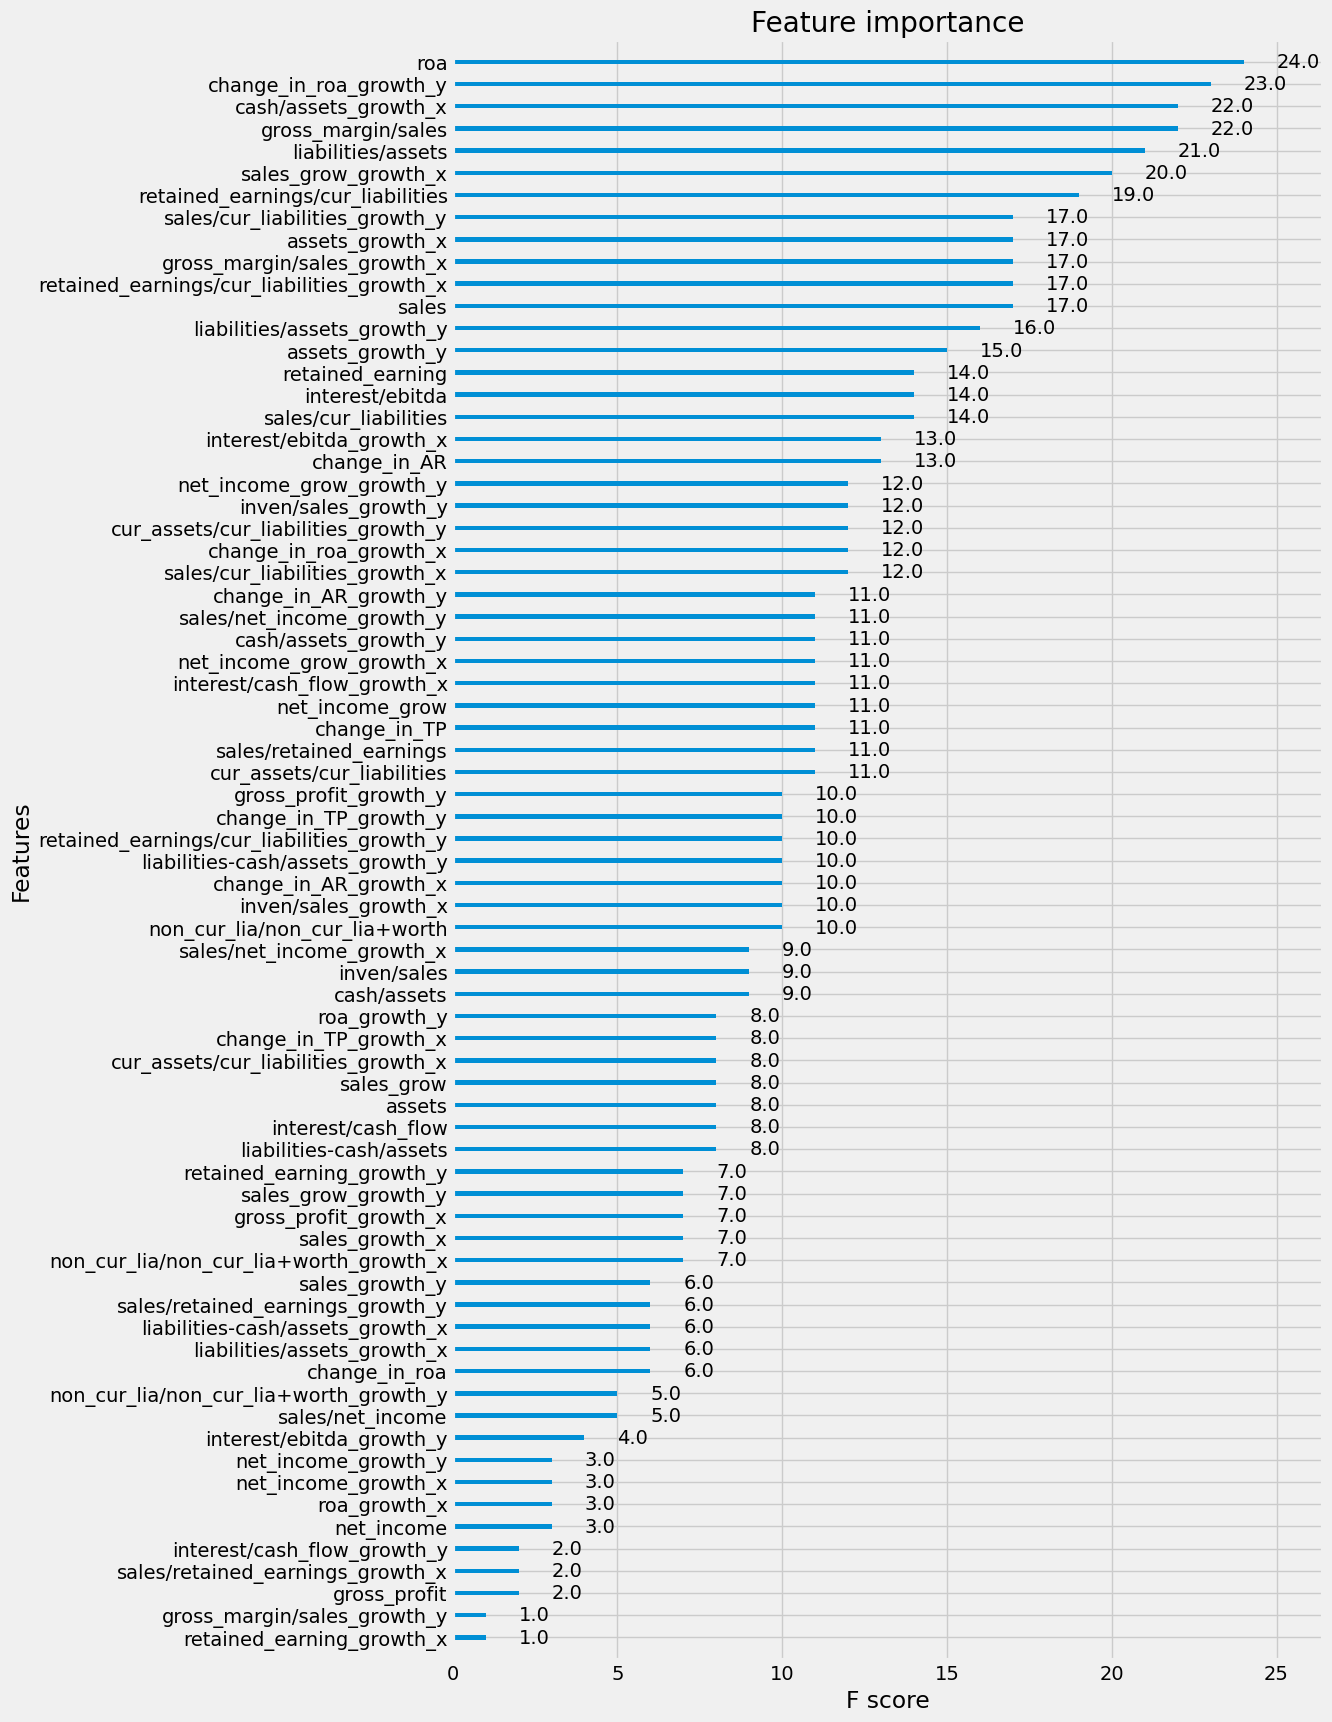

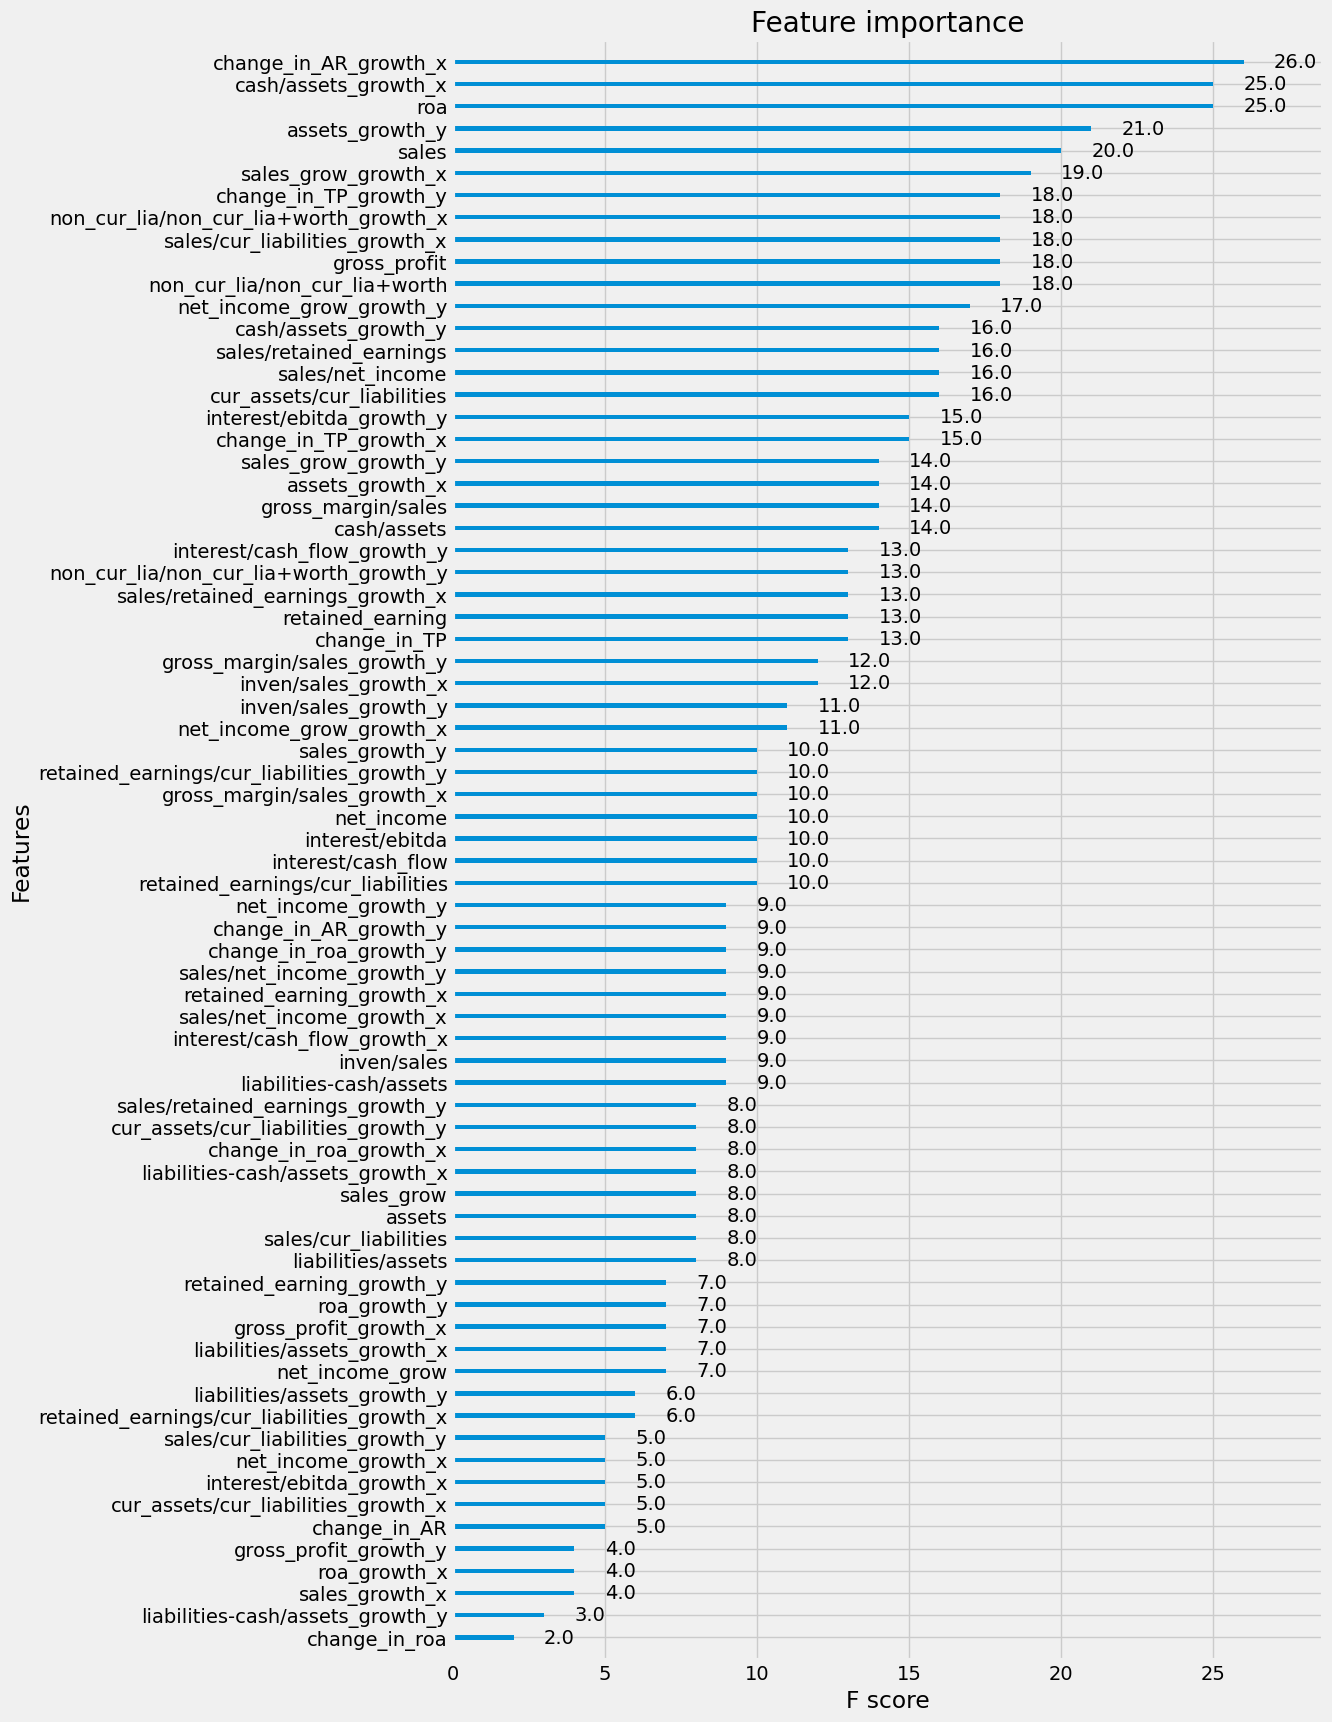

In [ ]:
uni_pnl_growth12 = uni_pnl_growth12[ list(uni_pnl_growth12.loc[:,'year':'retained_earning_growth_x'].columns) + list(uni_pnl_growth12.loc[:,'cash/assets_growth_y':'retained_earning_growth_y'].columns) + list(uni_pnl_growth12.loc[:,'fnc_rsn_unlst_year':'y_shift3'].columns) ]
All_shift_xgb_smltn(uni_pnl_growth12, 'cash/assets', 'retained_earning_growth_y')

In [ ]:
# All_shift_xgb_smltn(trn_grwth1, 'cash/assets_0', 'retained_earning_growth_1')

# #4. SMOTE 업샘플링

In [ ]:
## SMOTE 전처리 NAN과 inf값 drop
upsmpl_df = union_pnl_growth.loc[:,'cash/assets':'retained_earning_growth']
upsmpl_df.replace([np.inf, -np.inf], np.nan, inplace=True) #inf drop
upsmpl = upsmpl_df.dropna(axis=0) #Nan drop
upsmpl_nan = upsmpl_df.loc[set(upsmpl_df.index)-set(upsmpl.index)]

upsmpl.reset_index(drop=True, inplace=True) #Nan drop

upsmpl_X = upsmpl.drop(['fnc_rsn_unlst_year'],axis=1)
upsmpl_y = upsmpl['fnc_rsn_unlst_year']

print('[ not Nan ] \n', upsmpl.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count(), '\n')
print('[ contain Nan ] \n', upsmpl_nan.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

KeyError: ignored

In [ ]:
upsmpl.head(3)

NameError: ignored

## (1) SMOTE 종류

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [ ]:
## 업샘플링 데이터는 학습데이터로만 사용
## validation, test 데이터는 panel_a만 사용

def loop_up_samplingt(X, y, method, percent):

  X_train_val,X_test,y_train_val,y_test= train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
  X_train,X_val,y_train,y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val, shuffle=True)

  if method == 'SMOTE':
    smote = SMOTE(sampling_strategy=percent, random_state=0)
    df_up, Y_smt = smote.fit_resample(X_train, y_train)
    df_up['fnc_rsn_unlst_year'] = Y_smt
    print(df_up.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  if method == 'ADASYN':
    adasyn = ADASYN(sampling_strategy=percent, random_state=0)
    df_up, Y_adsn = adasyn.fit_resample(X_train, y_train)
    df_up['fnc_rsn_unlst_year'] = Y_adsn
    print(df_up.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  if method == 'tomek':
    smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=0)
    df_up, Y_smtto = smoteto.fit_resample(X_train, y_train)
    df_up['fnc_rsn_unlst_year'] = Y_smtto
    cnt_1 = int(len(df_up[df_up['fnc_rsn_unlst_year']==0])*percent)
    random_indices = np.random.choice(df_up[df_up['fnc_rsn_unlst_year']==1].index, cnt_1, replace=False)
    random_indices = np.concatenate([df_up[df_up['fnc_rsn_unlst_year']==0].index, random_indices])
    df_up = df_up.loc[random_indices].reset_index(drop=True)
    print(df_up.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  X_up = df_up.drop(['fnc_rsn_unlst_year'],axis=1)
  y_up = df_up['fnc_rsn_unlst_year']

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_up, y_up, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre
  X_test['y_pred_probs'] = y_pred_probs

  return X_test

# result_smote = loop_up_samplingt(upsmpl_X, upsmpl_y, 'SMOTE', 0.25)
# result_adasyn = loop_up_samplingt(upsmpl_X, upsmpl_y, 'ADASYN', 0.25)
# result_tomek = loop_up_samplingt(upsmpl_X, upsmpl_y, 'tomek', 0.25)

In [ ]:
# result_summary(result_smote, 'SMOTE result')
# print('------------------------------------------'+'\n')
# result_summary(result_adasyn, 'ADASYN result')
# print('------------------------------------------'+'\n')
# result_summary(result_tomek, 'SMOTETomek result')

## (2) 업샘플링 비율

In [ ]:
## n별 정확도

def loop_score(X, y, method, per_list):
  result_score = pd.DataFrame()
  term_list = []
  score_list = []
  list_0 = []
  list_1 = []

  for per in per_list:
    term_list.append(per)
    result = loop_up_samplingt(upsmpl_X, upsmpl_y, method, per)

    ## 정확도
    score = accuracy_score(result['y_pred'], result['y_real'])
    score_list.append(round(score,4))

    ## 오답 개수
    cnt = result.groupby(['y_real','y_pred'])[['y_pred']].count()
    if len(cnt.index) == 4:
      whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
      wrng0_cnt = cnt.loc[(0,1),('y_pred')]
      list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

      whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
      wrng1_cnt = cnt.loc[(1,0),('y_pred')]
      list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


    elif len(cnt.index) == 3: ## pred_y가 0인 값은 무조건 있으므로 (0, 1)와 (1, 1) 값이 없는 대부분
      if cnt.index.isin([(0, 1)])[1] == True: #(0, 0), (0, 1), (1, 0)
        whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
        wrng0_cnt = cnt.loc[(0,1),('y_pred')]
        list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

        all_wrng = 1
        list_1.append(round((all_wrng)*100, 3))
      else: #(0, 0), (1, 0), (1, 1)
        all_wrng = 1
        list_0.append(round((all_wrng)*100, 3))

        whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
        wrng1_cnt = cnt.loc[(1,0),('y_pred')]
        list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))

    else: #(0, 0), (1, 0)
      all_wrng = 1
      all_crrct = 0
      list_0.append(round(all_crrct*100, 3))
      list_1.append(round(all_wrng*100, 3))

  result_score['term'] = term_list
  result_score['score'] = score_list
  result_score['real0_pred1(%)'] = list_0
  result_score['real1_pred0(%)'] = list_1

  return result_score

# result_smote_loop = loop_score(upsmpl_X, upsmpl_y, 'SMOTE', [0.25, 0.5, 0.75])
# result_adasyn_loop = loop_score(upsmpl_X, upsmpl_y, 'ADASYN', [0.25, 0.5, 0.75])
# result_tomek_loop = loop_score(upsmpl_X, upsmpl_y, 'tomek', [0.25, 0.5, 0.75])

In [ ]:
result_smote_loop

,term,score,real0_pred1(%),real1_pred0(%)
0,0.25,0.9796,0.863,75.676
1,0.50,0.9737,1.511,72.973
2,0.75,0.9728,1.640,70.270


In [ ]:
# result_adasyn_loop

In [ ]:
# result_tomek_loop

## (3) 업샘플링 방식 XGB

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [ ]:
def xgb_with_up_sampling(union_df, method, percent):

  ## SMOTE 전처리 NAN과 inf값 drop
  union_df.replace([np.inf, -np.inf], np.nan, inplace=True) #inf drop
  upsmpl = union_df.dropna(axis=0) #Nan drop(upsampling용)
  upsmpl_nan = union_df.loc[set(union_df.index)-set(upsmpl.index)] # contain Nan(val, test용)

  upsmpl.reset_index(drop=True, inplace=True)

  ## 학습
  upsmpl_X = upsmpl.drop(['fnc_rsn_unlst_year'],axis=1)
  upsmpl_y = upsmpl['fnc_rsn_unlst_year']

  print('[ train data ] \n', upsmpl.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count(), '\n')
  print('[ val, test data ] \n', upsmpl_nan.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count(), '\n')

  X_train,X_test,y_train,y_test= train_test_split(upsmpl_X, upsmpl_y, test_size=0.2, random_state=1, stratify=upsmpl_y, shuffle=True)
  X_test = pd.concat([X_test, upsmpl_nan.drop(['fnc_rsn_unlst_year'],axis=1)]) # + contain Nan(val, test용)
  y_test = pd.concat([y_test, upsmpl_nan['fnc_rsn_unlst_year']]) # + contain Nan(val, test용)

  X_val,X_test,y_val,y_test= train_test_split(X_test, y_test, test_size=0.7, random_state=1, stratify=y_test, shuffle=True)

  if method == 'SMOTE':
    smote = SMOTE(sampling_strategy=percent, random_state=0)
    df_up, Y_smt = smote.fit_resample(X_train, y_train)
    df_up['fnc_rsn_unlst_year'] = Y_smt
    print('[ SMOTE up sampling train data ] \n', df_up.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  if method == 'ADASYN':
    adasyn = ADASYN(sampling_strategy=percent, random_state=0)
    df_up, Y_adsn = adasyn.fit_resample(X_train, y_train)
    df_up['fnc_rsn_unlst_year'] = Y_adsn
    print(df_up.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  if method == 'tomek':
    smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=0)
    df_up, Y_smtto = smoteto.fit_resample(X_train, y_train)
    df_up['fnc_rsn_unlst_year'] = Y_smtto
    cnt_1 = int(len(df_up[df_up['fnc_rsn_unlst_year']==0])*percent)
    # random_indices = np.random.choice(df_up[df_up['fnc_rsn_unlst_year']==1].index, cnt_1, replace=False)
    # random_indices = np.concatenate([df_up[df_up['fnc_rsn_unlst_year']==0].index, random_indices])
    # df_up = df_up.loc[random_indices].reset_index(drop=True)
    print(df_up.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  X_up = df_up.drop(['fnc_rsn_unlst_year'],axis=1)
  y_up = df_up['fnc_rsn_unlst_year']

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_up, y_up, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre
  X_test['y_pred_probs'] = y_pred_probs

  return X_test

result_nan = xgb_with_up_sampling(pnl_growth1234.loc[:,'cash/assets':'fnc_rsn_unlst_year'], 'tomek', 0.25)

[ train data ] 
 fnc_rsn_unlst_year
0    9666
1     122
Name: fnc_rsn_unlst_year, dtype: int64 

[ val, test data ] 
 fnc_rsn_unlst_year
0    44107
1      457
Name: fnc_rsn_unlst_year, dtype: int64 

fnc_rsn_unlst_year
0    7708
1    7732
Name: fnc_rsn_unlst_year, dtype: int64
[0]	validation_0-logloss:0.54239
[1]	validation_0-logloss:0.47672
[2]	validation_0-logloss:0.42595
[3]	validation_0-logloss:0.38217
[4]	validation_0-logloss:0.34031
[5]	validation_0-logloss:0.30319
[6]	validation_0-logloss:0.30953
[7]	validation_0-logloss:0.26592
[8]	validation_0-logloss:0.25222
[9]	validation_0-logloss:0.22394
[10]	validation_0-logloss:0.22021
[11]	validation_0-logloss:0.20635
[12]	validation_0-logloss:0.20739
[13]	validation_0-logloss:0.19823
[14]	validation_0-logloss:0.18536
[15]	validation_0-logloss:0.18280
[16]	validation_0-logloss:0.17475
[17]	validation_0-logloss:0.17613
[18]	validation_0-logloss:0.16384
[19]	validation_0-logloss:0.15586
[20]	validation_0-logloss:0.14638
[21]	validation_0-

In [ ]:
result_summary(result_nan, 'upsampling train data without contained_nan and test with contained_nan')

[  upsampling train data without contained_nan and test with contained_nan  ] 

정확도: 0.9819443591475773
y_real  y_pred
0       0         31911
        1           318
1       0           270
        1            67
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 318 / 32229
상장폐지를 상장유지로 예측: 270 / 337 

오답률: 0.0099
오답률: 0.8012


# 5.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.models import load_model
import configparser
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.layers import Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
pnl_X = pnl.loc[:,'cash/assets':'retained_earning']
pnl_Y = pnl[['fnc_rsn_unlst_year', 'y_shift1', 'y_shift2', 'y_shift3']]

In [ ]:
## 시드 고정
import random
import os

def seed_everthing(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  tf.random.set_seed(seed)

seed_everthing(1)

In [ ]:
pnl_dl = pnl_growth1234.set_index('year')
pnl_dl

,code_label,cash/assets,liabilities/assets,liabilities-cash/assets,sales/cur_liabilities,cur_assets/cur_liabilities,retained_earnings/cur_liabilities,non_cur_lia/non_cur_lia+worth,interest/cash_flow,interest/ebitda,inven/sales,sales/net_income,gross_margin/sales,sales/retained_earnings,change_in_roa,change_in_AR,change_in_TP,assets,sales,roa,sales_grow,net_income,net_income_grow,gross_profit,operating_profit,retained_earning,cash/assets_growth_1,liabilities/assets_growth_1,liabilities-cash/assets_growth_1,sales/cur_liabilities_growth_1,cur_assets/cur_liabilities_growth_1,retained_earnings/cur_liabilities_growth_1,non_cur_lia/non_cur_lia+worth_growth_1,interest/cash_flow_growth_1,interest/ebitda_growth_1,inven/sales_growth_1,sales/net_income_growth_1,gross_margin/sales_growth_1,sales/retained_earnings_growth_1,change_in_roa_growth_1,change_in_AR_growth_1,change_in_TP_growth_1,assets_growth_1,sales_growth_1,roa_growth_1,sales_grow_growth_1,net_income_growth_1,net_income_grow_growth_1,gross_profit_growth_1,operating_profit_growth_1,...,cur_assets/cur_liabilities_growth_3,retained_earnings/cur_liabilities_growth_3,non_cur_lia/non_cur_lia+worth_growth_3,interest/cash_flow_growth_3,interest/ebitda_growth_3,inven/sales_growth_3,sales/net_income_growth_3,gross_margin/sales_growth_3,sales/retained_earnings_growth_3,change_in_roa_growth_3,change_in_AR_growth_3,change_in_TP_growth_3,assets_growth_3,sales_growth_3,roa_growth_3,sales_grow_growth_3,net_income_growth_3,net_income_grow_growth_3,gross_profit_growth_3,operating_profit_growth_3,retained_earning_growth_3,cash/assets_growth_4,liabilities/assets_growth_4,liabilities-cash/assets_growth_4,sales/cur_liabilities_growth_4,cur_assets/cur_liabilities_growth_4,retained_earnings/cur_liabilities_growth_4,non_cur_lia/non_cur_lia+worth_growth_4,interest/cash_flow_growth_4,interest/ebitda_growth_4,inven/sales_growth_4,sales/net_income_growth_4,gross_margin/sales_growth_4,sales/retained_earnings_growth_4,change_in_roa_growth_4,change_in_AR_growth_4,change_in_TP_growth_4,assets_growth_4,sales_growth_4,roa_growth_4,sales_grow_growth_4,net_income_growth_4,net_income_grow_growth_4,gross_profit_growth_4,operating_profit_growth_4,retained_earning_growth_4,fnc_rsn_unlst_year,y_shift1,y_shift2,y_shift3
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990,5930,0.026243,0.805812,0.779569,2.738511,0.948362,0.223232,0.672144,0.000012,0.000008,0.160206,61.788109,0.232182,12.267552,-0.644068,0.376302,0.078972,4.057249e+09,4.511718e+09,2.10,12.60,7.301920e+07,-53.930000,1.047541e+09,-53.930000,3.677766e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1991,5930,0.011561,0.825602,0.814041,1.887630,0.740129,0.145565,0.651638,0.000000,0.000000,0.174542,76.166253,0.272677,12.967588,-0.319048,0.217245,0.239576,5.551880e+09,5.227130e+09,1.43,15.86,6.862790e+07,-6.010000,1.425316e+09,-6.010000,4.030919e+08,-0.559457,0.024559,0.044219,-0.310709,-0.219571,-0.347920,-0.030507,-1.000000,-1.000000,0.089481,0.232701,0.174407,0.057064,-0.504637,-0.422686,2.033675,0.368385,0.158567,-0.319048,0.258730,-0.060139,-0.888559,0.360630,-0.888559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1992,5930,0.026253,0.819760,0.793507,2.032037,0.708325,0.146367,0.656881,0.001486,0.000561,0.142004,84.247871,0.272204,13.883191,-0.146853,-0.135195,-0.194717,6.326672e+09,6.102773e+09,1.22,16.75,7.243830e+07,5.550000,1.661199e+09,5.550000,4.395800e+08,1.270775,-0.007076,-0.025224,0.076502,-0.042972,0.005506,0.008045,NaN,NaN,-0.186417,0.106105,-0.001733,0.070607,-0.539714,-1.622316,-1.812755,0.139555

In [ ]:
def lstm_model(X_train, y_train, X_test, y_test):
  # X_train = X_train.values
  # X_train = np.array(X_train)[index.astype(int)]
  # X_train = X_train.reshape(X_train.shape[0], X_train[1], 1)

  model = Sequential()
  model.add(layers.Dense(128, input_shape=(X_train.shape[0], X_train[1], 1) , return_sequences=True))
  model.add(layers.Dense(128, return_sequences=True))
  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  # checkpoint = ModelCheckpoint(filepath = f"/content/drive/MyDrive/학교/연구 자료/기후금융/model/model_{i}.h5", monitor='val_loss', save_best_only=True) #f"/content/drive/MyDrive/Colab Notebooks/gdp_re/model/moel_{i}.h5"
  # early_stopping = EarlyStopping(monitor='val_loss', patience =60, mode='min')

  initial_learning_rate = 1e-4
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps = 100, decay_rate = 0.96, staircase=True)
  # scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

  X_train
  hist = model.fit(X_train, y_train, validation_data =(X_test, y_test), epochs=150) #, callbacks=[checkpoint, early_stopping, scheduler]
  # model_file = [fl for fl in os.listdir("/content/drive/MyDrive/학교/연구 자료/기후금융/model") if re.findall(f"model_{i}", fl)][0] # 모델을 저장할 경로를 지정해주셔야 합니다.
  # model = load_model(f"/content/drive/MyDrive/학교/연구 자료/기후금융/model/{model_file}") # 모델을 불러올 경로를 지정해주셔야 합니다. 위의 경로와 같습니다.

  return model

In [ ]:

from keras.backend import rnn
sample_size = len(pnl_dl)
predicted_y = []

df_train = pnl_dl[pnl_dl.index < 2015] # 학습데이터
window = len(df_train) # 윈도우 사이즈 설정 (2002~2015)


df_test = pnl_dl[pnl_dl.index >= 2015] #검증데이터
forecast_horizon = len(df_test) # 검증데이터 길이

start_index = 0

# fit the model and make a forecast
for i in tqdm(range(forecast_horizon)): #검증데이터만큼 돌린다

    # writer = SummaryWriter()

    end_index = start_index + window
    new_data = pnl_dl.iloc[start_index : end_index] # df에서 end_index+1

    x_train, x_val, y_train, y_val = train_test_split(new_data.drop(['code_label', 'fnc_rsn_unlst_year',	'y_shift1',	'y_shift2',	'y_shift3'], axis =1), new_data["fnc_rsn_unlst_year"] ,test_size = 0.25, shuffle = False)

    # gets the trained neural network with given data
    model = lstm_model(x_train, y_train, x_val, y_val) #lstm_model함수는 hist를 return해줌

    x_new = pnl_dl.iloc[end_index]
    x_new = pd.DataFrame(x_new).T.drop(["Y"], axis = 1)
    y_pred = model.predict(x_new)
    # y_pred = y_pred[0][0]

    predicted_y.append(y_pred)
    print(y_pred)

    start_index = start_index + 1 # for rolling-window forecasts

    # window = window + 1 # for recursive forecasts


  0%|          | 0/15543 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
def lstm_smlt(df, y_col):

  # scaler = MinMaxScaler(feature_range=(0,1))
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(X.values)
  X = pd.DataFrame(np_scaled, columns=X.columns)

  X_train_val,X_test,y_train_val,y_test= train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
  X_train,X_val,y_train,y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val, shuffle=True)

  sample_size = len(df)
  predicted_y = []

  df_train = df[df.index < 2015] # 학습데이터
  window = len(df_train) # 윈도우 사이즈 설정 (2002~2015)


  df_test = df[df.index >= 2015] #검증데이터
  forecast_horizon = len(df_test) # 검증데이터 길이

  start_index = 0

  # fit the model and make a forecast
  for i in tqdm(range(forecast_horizon)): #검증데이터만큼 돌린다

      # writer = SummaryWriter()

      end_index = start_index + window
      new_data = df.iloc[start_index : end_index] # df에서 end_index+1

      x_train, x_val, y_train, y_val = train_test_split(new_data.drop(["Y"], axis =1), new_data["Y"] ,test_size = 0.25, shuffle = False)

      # gets the trained neural network with given data
      model = lstm_model(x_train, y_train, x_val, y_val) #lstm_model함수는 hist를 return해줌

      x_new = df.iloc[end_index]
      x_new = pd.DataFrame(x_new).T.drop(["Y"], axis = 1)
      y_pred = model.predict(x_new)
      # y_pred = y_pred[0][0]

      predicted_y.append(y_pred)
      print(y_pred)

      start_index = start_index + 1 # for rolling-window forecasts

      # window = window + 1 # for recursive forecasts

  return

In [ ]:
lstm_smlt(pnl_dl, 'fnc_rsn_unlst_year')

UnboundLocalError: ignored